## Generates various plots for documentation purposes

In [1]:
import pandas as pd
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import utility_functions as utility
import re
import numpy as np
import itertools
from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager

default_font_size = 30
plt.rcParams['font.size'] = default_font_size

Load data and simplify column names for better readability. Afterwards merge into one DataFrame

In [6]:
base_path = 'Data'
index_columns = ['Run Id','Sample Id']

parameter_df = pd.read_csv(path.join(base_path,'metadata_parameter.csv'))
energy_df = pd.read_csv(path.join(base_path,'metadata_energy.csv'))
energy_df.drop('Total_Cycles',inplace=True, axis=1)
agility_df = pd.read_csv(path.join(base_path,'metadata_agility.csv'))

def camel_case_to_delimiter(str):
	words = [[str[0]]]
	for c in str[1:]:
		if words[-1][-1].islower() and c.isupper():
			words.append(list(c))
		else:
			words[-1].append(c)
	return '_'.join([''.join(word) for word in words])


def simplify_column_name(str2):
    if str2 is None:
        return str2
    else:
        return ' '.join([s.capitalize() for s in camel_case_to_delimiter(str2).split('_')])

energy_df.rename(columns=simplify_column_name, inplace=True)
agility_df.rename(columns=simplify_column_name, inplace=True)
parameter_df.rename(columns=simplify_column_name, inplace=True)

agility_df = agility_df.groupby('Func').get_group('mean').drop('Func', axis=1)

metadata_df = parameter_df\
    .merge(energy_df, on=index_columns)\
    .merge(agility_df, on=index_columns)\
    .set_index(index_columns)

Some helper functions for plotting

In [7]:
def create_heatmap(matrix_df, columns):
    if columns is not None:
        matrix_df = matrix_df.drop(matrix_df.columns.intersection(columns), axis=0)\
        .drop(matrix_df.index.difference(columns), axis=1)
    return matrix_df

def print_heatmap(matrix_df, columns, **kwargs):
    plt.figure(**kwargs)
    return sns.heatmap(create_heatmap(matrix_df, columns), annot=True, vmin=-1, vmax=1, center=0, fmt='.2f')

def print_standard_heatmap(matrix_df, columns, **kwargs):
    plt.figure(**kwargs)
    return sns.heatmap(create_heatmap(matrix_df, columns), annot=True)

def reduce_labels(axis: plt.axis, visible_index: int):
    label_index = 0
    last_label = None
    for label in axis.get_ticklabels():
        label.set_visible((label_index % visible_index) == 0)
        label_index += 1
        last_label = label
    last_label.set_visible(True)


Mean energy values of 20220205-223511

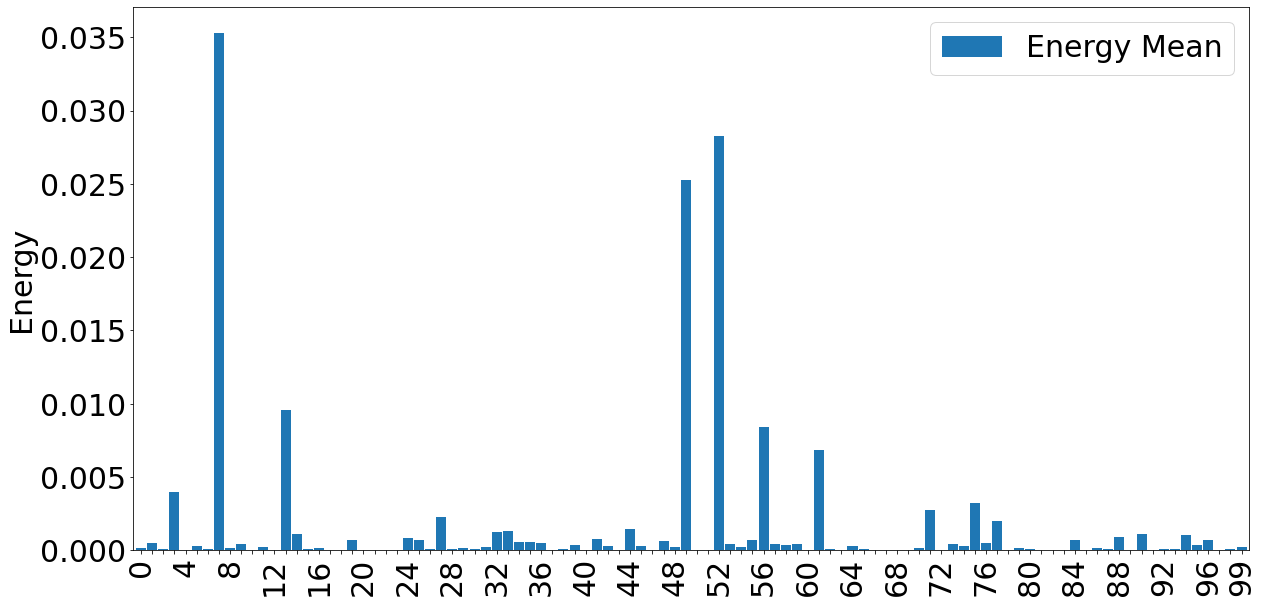

In [5]:
acc_df = metadata_df.xs('20220205-223511')[['Energy Mean']]\
    .reset_index()\
    .rename(columns=lambda x: x.replace('_', ' '))

ax = acc_df.plot.bar(figsize=(20, 10), ylabel=r'Energy',
                     width=0.9)
reduce_labels(ax.xaxis, 4)
ax.get_figure().savefig('Figures/20220205-223511_energy_mean')

Mean agility values of 20220205-223511

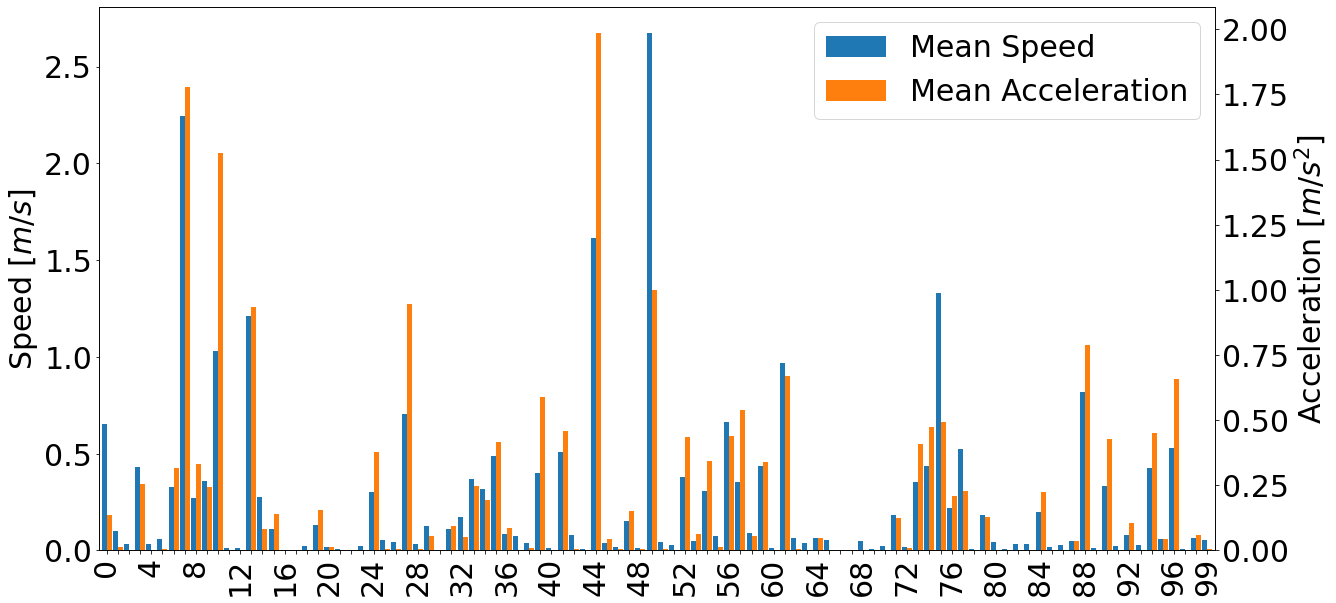

In [6]:
acc_df = metadata_df.xs('20220205-223511')[['Mean Speed','Mean Acceleration']]\
    .reset_index()\
    .rename(columns=lambda x: x.replace('_', ' '))

ax = acc_df.plot.bar(figsize=(20, 10), secondary_y='Mean Acceleration', mark_right=False,
                     width=0.9)
reduce_labels(ax.xaxis, 4)
ax.set_ylabel(r'Speed [$m/s$]')
ax.right_ax.set_ylabel(r'Acceleration [$m/s^2$]')
ax.get_figure().savefig('Figures/20220205-223511_agility_mean')

Energy-Measure correlation matrix for all correlation related runs (Correlation_Test 1-4)

<ipython-input-7-63d2fc637259>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax.get_figure().savefig('Figures/correlation_energy', title='Energy', bbox_inches='tight' )


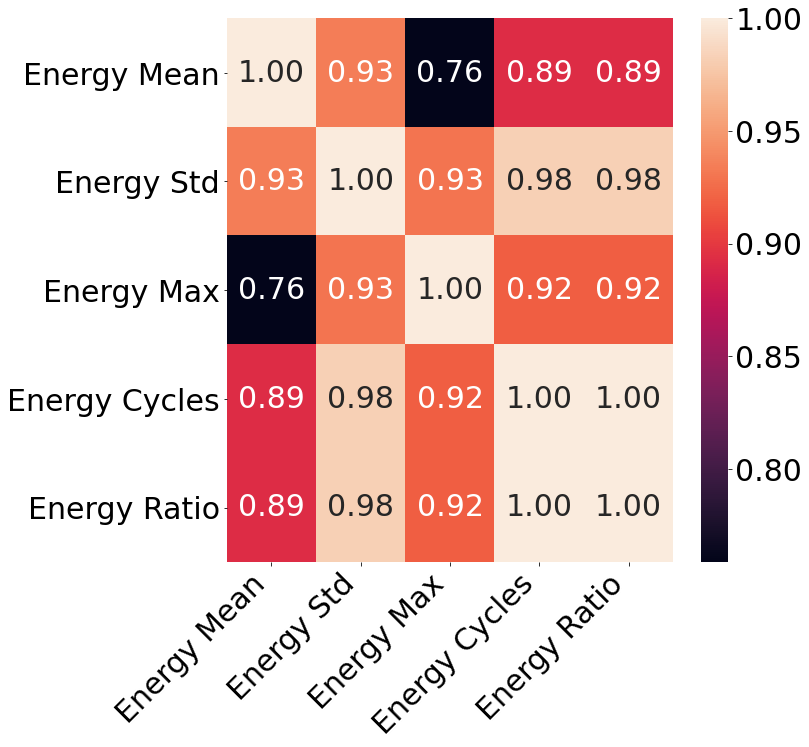

In [7]:
energy_corr_df = energy_df[~energy_df['Run Id'].str.contains('Correlation')]
plt.figure(figsize = (10,10))
ax = sns.heatmap(energy_corr_df.corr(method='pearson'), annot=True, fmt='.2f')
plt.xticks(rotation=45, ha='right')
ax.get_figure().savefig('Figures/correlation_energy', title='Energy', bbox_inches='tight' )

Agility-Measure correlation matrix for all correlation related runs (Correlation_Test 1-4)

<ipython-input-8-e6d098dab0bd>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax.get_figure().savefig('Figures/correlation_agility', title='Agility', bbox_inches='tight')


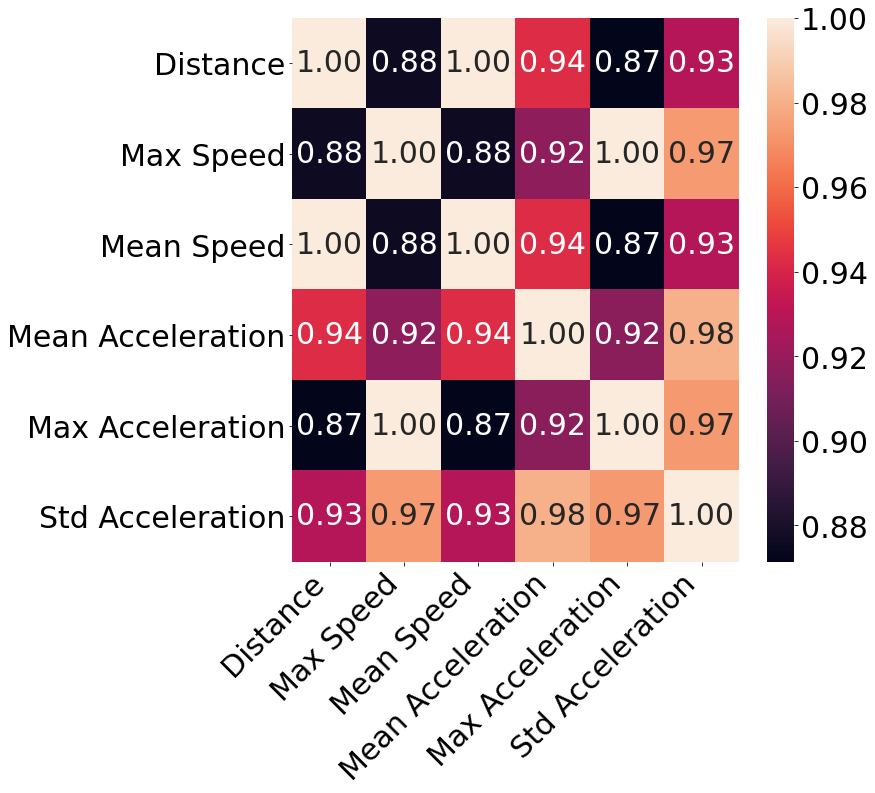

In [8]:
agility_corr_df = agility_df[~agility_df['Run Id'].str.contains('Correlation')]
plt.figure(figsize = (10,10))
ax = sns.heatmap(agility_corr_df.corr(method='pearson'), annot=True, fmt='.2f')
plt.xticks(rotation=45, ha='right')
ax.get_figure().savefig('Figures/correlation_agility', title='Agility', bbox_inches='tight')

## Plots of Run 20220205-223511

Correlation matrix between Energy/Agility-Measures and Input Parameters

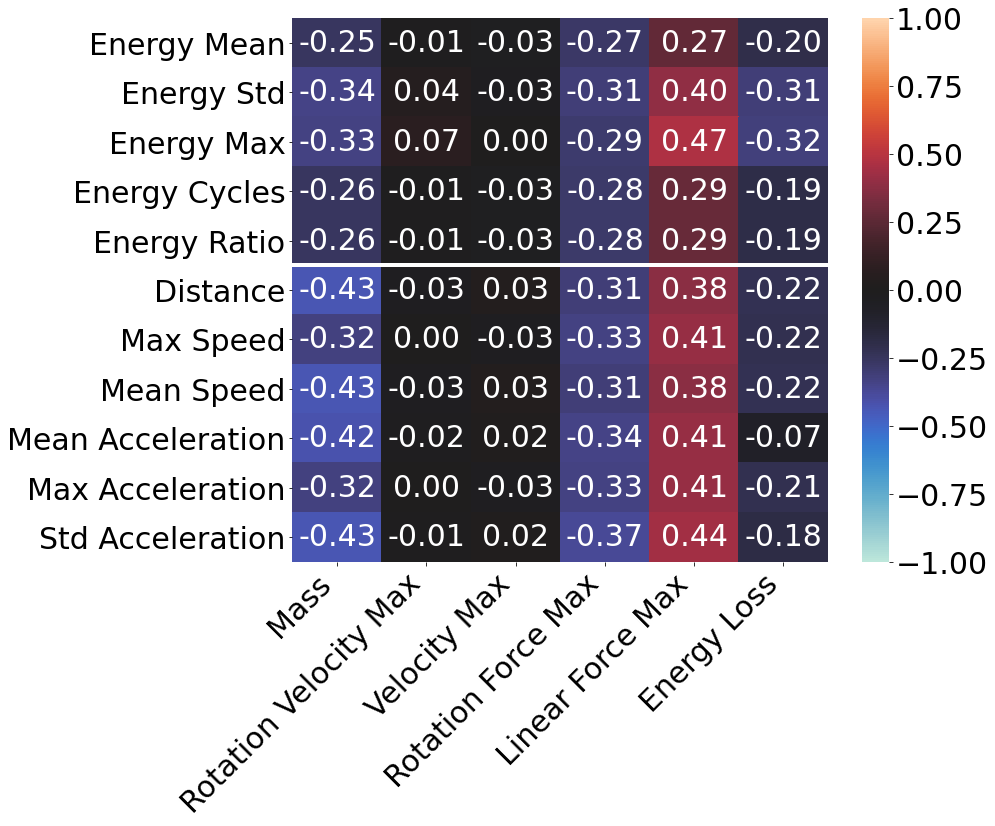

In [9]:
matrix = metadata_df.drop(columns=['Consumption Rate']).xs('20220205-223511').corr(method='pearson')
ax = print_heatmap(matrix, parameter_df.columns, figsize = (12,10))
plt.xticks(rotation=45, ha='right')
ax.axhline(5,lw=4, color='white')
ax.get_figure().savefig('Figures/20220205-223511_meta_corr', bbox_inches='tight')

Correlation between energy and agility

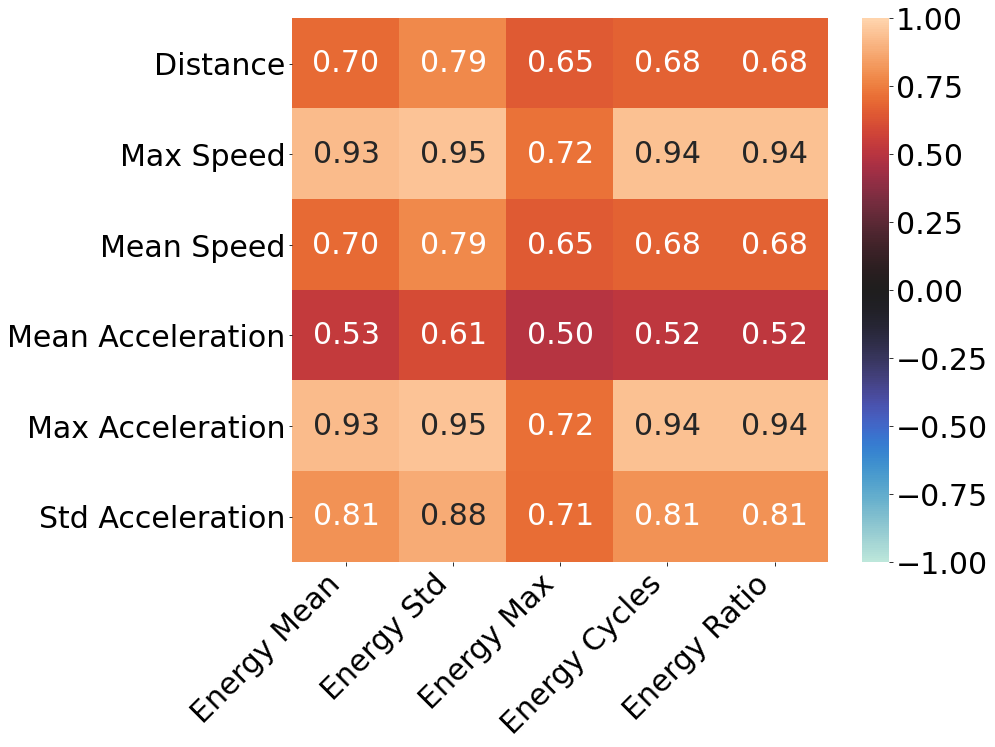

In [8]:
matrix = metadata_df\
    .drop(columns=set(parameter_df.columns)-set(index_columns))\
    .xs('20220205-223511')\
    .corr(method='pearson')

ax = print_heatmap(matrix, energy_df.columns, figsize = (12,10))
plt.xticks(rotation=45, ha='right')
ax.get_figure().savefig('Figures/20220205-223511_measure_corr', bbox_inches='tight')

The Highest correlation between energy and agility

In [9]:
matrix_2 = matrix.drop(matrix.columns.intersection(energy_df.columns), axis=0)\
        .drop(matrix.index.difference(energy_df.columns), axis=1)
matrix_2.reset_index(inplace=True)
matrix_2 = pd.melt(matrix_2, value_vars=list(matrix_2.columns[1:]), id_vars='index')
matrix_2.set_index(['index', 'variable'], inplace=True)
matrix_2.sort_values('value', ascending=False, inplace=True)
matrix_2.head()

value
index            variable               
Max Speed        Energy Std     0.951426
Max Acceleration Energy Std     0.950235
                 Energy Cycles  0.938316
                 Energy Ratio   0.938316
Max Speed        Energy Cycles  0.938237

Average correlation between energy and agility

In [11]:
matrix_3 = matrix.drop(matrix.columns.intersection(energy_df.columns), axis=0)\
        .drop(matrix.index.difference(energy_df.columns), axis=1)
agility_corr_mean = pd.concat([matrix_3.mean(axis=0),matrix_3.mean(axis=1)])
print(agility_corr_mean)
print('Total: ' + str(agility_corr_mean.mean()))

Energy Mean          0.765549
Energy Std           0.826162
Energy Max           0.658667
Energy Cycles        0.759903
Energy Ratio         0.759903
Distance             0.699227
Max Speed            0.894699
Mean Speed           0.699227
Mean Acceleration    0.536065
Max Acceleration     0.894117
Std Acceleration     0.800886
dtype: float64
Total: 0.7540369043562805


## Plots of Correlation_Test4
Extract some metadata related to used base sample and group by the applied factor.
For more information about the factor and underlying function see the *Compare_Metadata* notebook under generator function.

In [15]:
corr_run4 = metadata_df.xs('Correlation_Test4').reset_index()
corr_run4['Factor'] = corr_run4.apply(lambda x: float(x['Sample Id'].split('_')[-1].replace('-','.')), axis=1)
corr_run4['Base Sample'] = corr_run4.apply(lambda x: '_'.join(x['Sample Id'].split('_')[:-1]),axis=1)
corr_run4.set_index(['Base Sample', 'Factor'], inplace=True)
factor_groups = [(name, group.groupby('Factor').mean()) for name, group in corr_run4.groupby('Base Sample')]

Energy Standard deviation based on the applied factor.

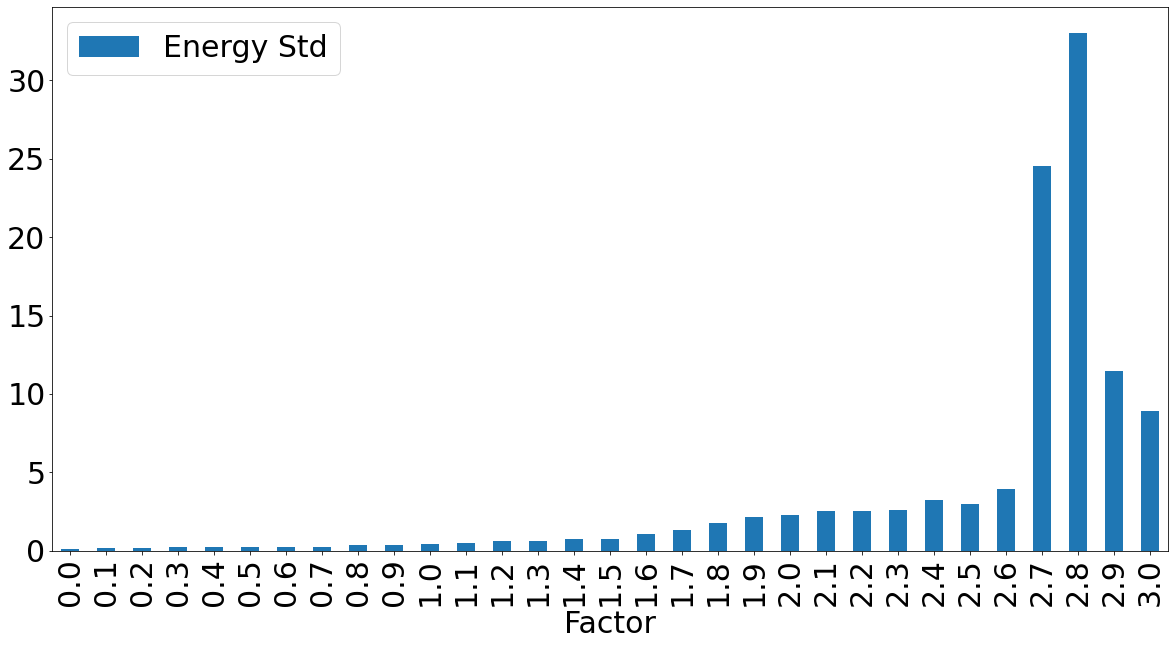

In [16]:
corr_run4\
    .groupby('Factor')\
    .mean()\
    .plot(kind='bar', y='Energy Std', figsize=(20,10))\
    .get_figure().savefig('Figures/Correlation_Test4_factors')

Energy Standard deviation per Sample based on the applied factor.


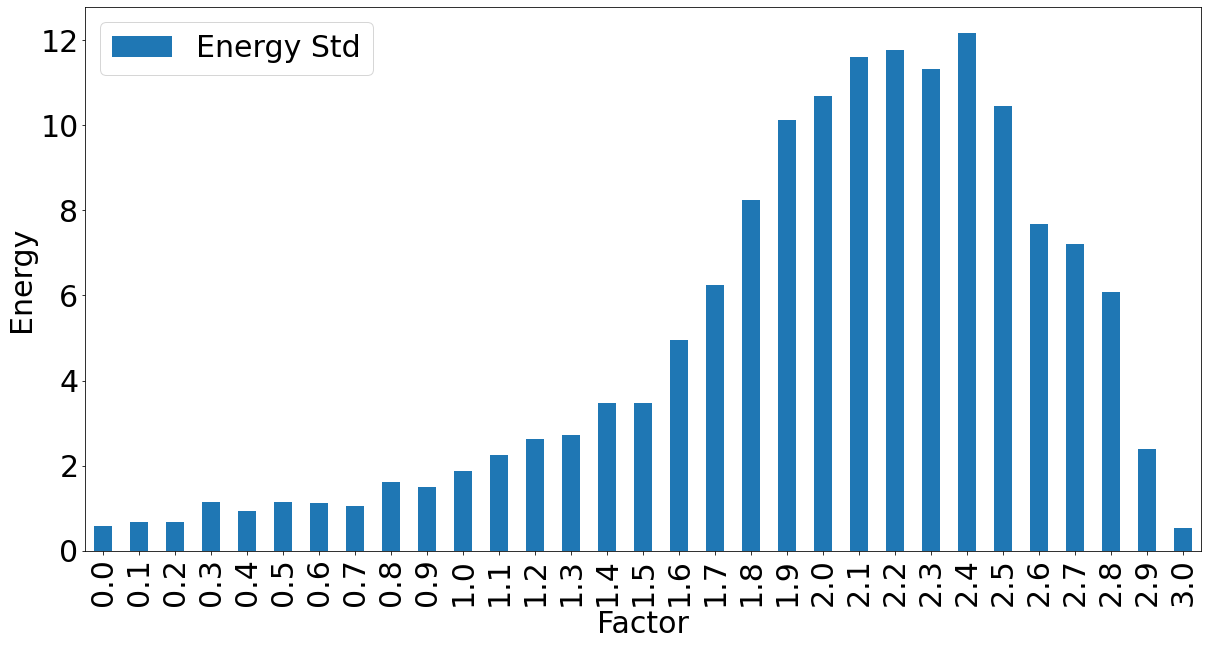

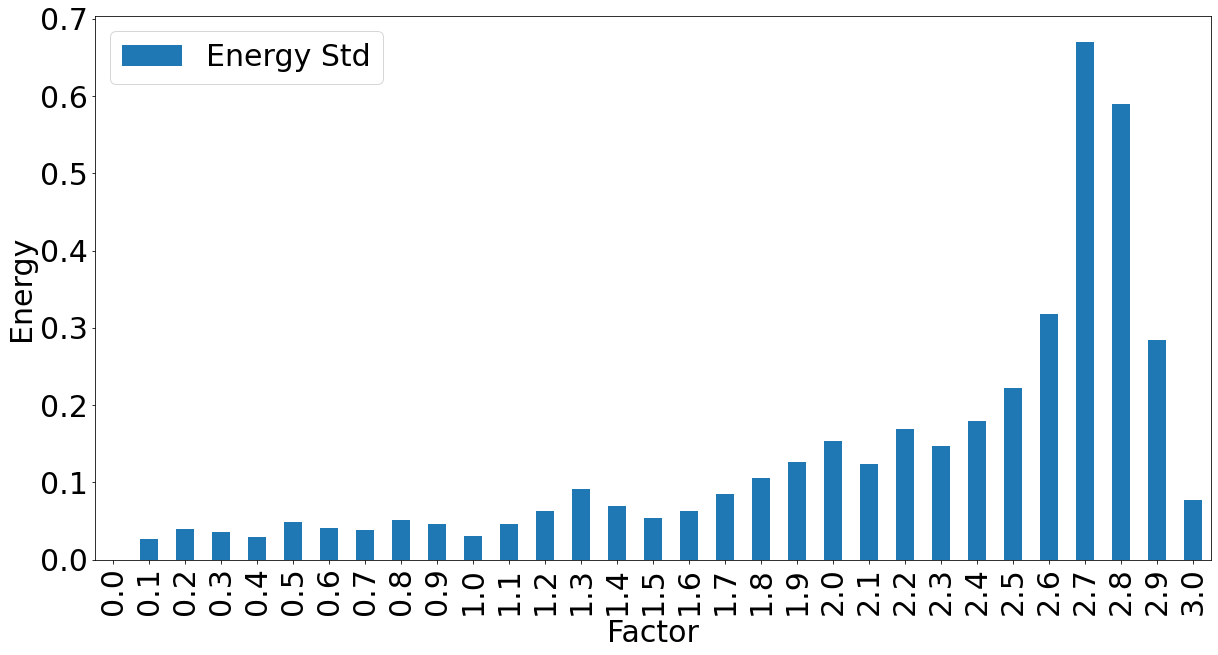

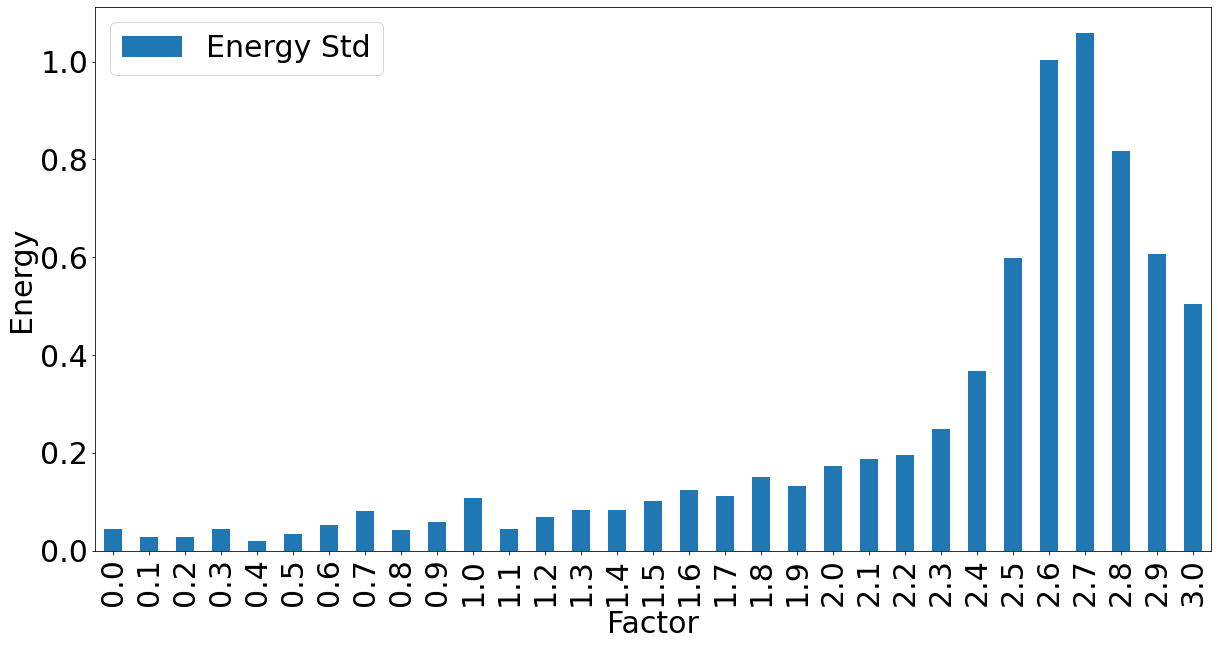

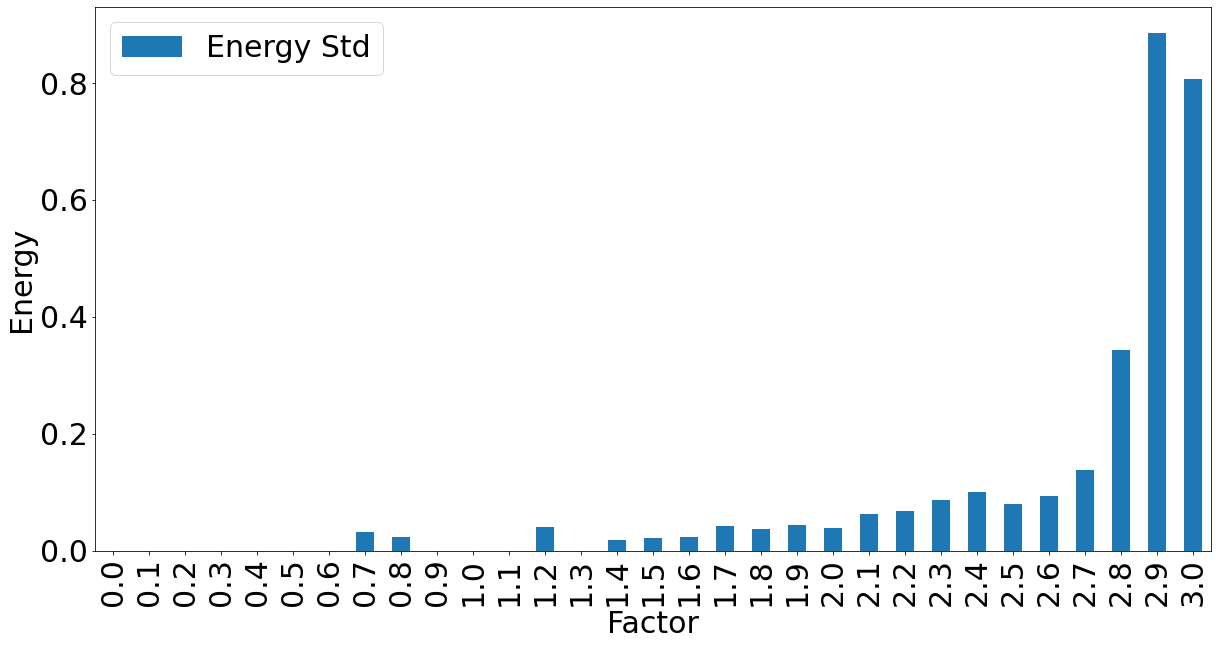

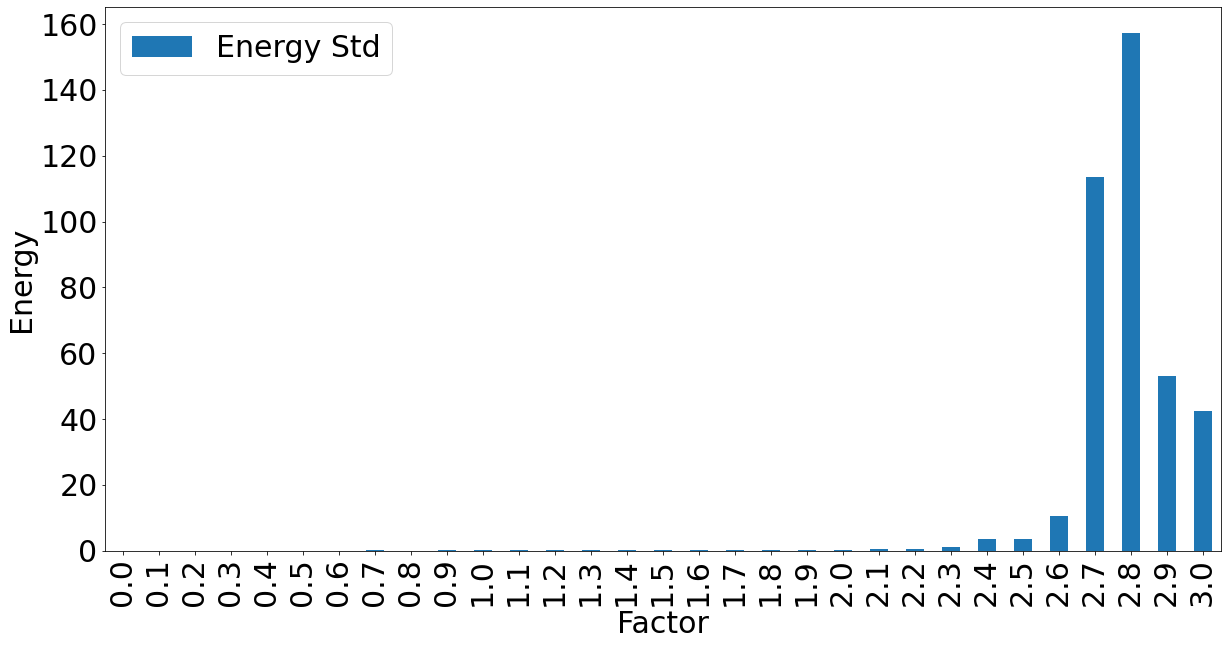

In [14]:
for name, group in factor_groups:
    ax =group.plot(kind='bar', y='Energy Std', figsize=(20,10),)
    ax.set_ylabel('Energy')
    ax.get_figure().savefig('Figures/Correlation_Test4_factors_' + name, bbox_inches='tight')

Energy Standard deviation per Sample based on the applied factor. Y-Scala is modified so that smaller values are better visible.

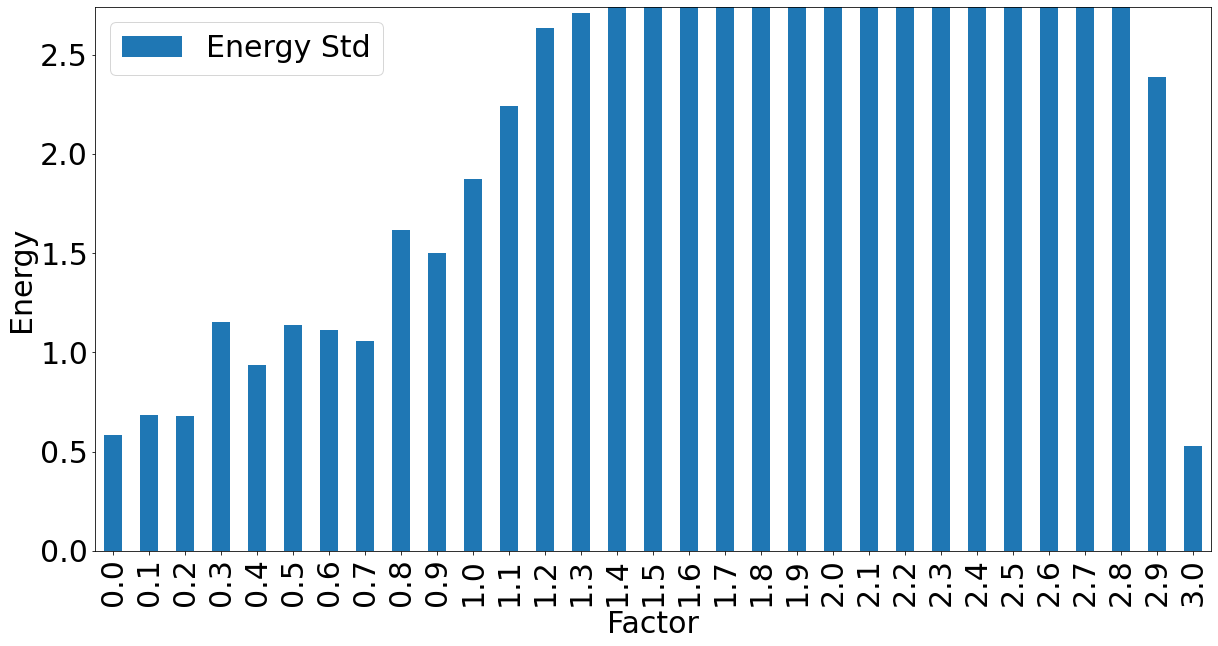

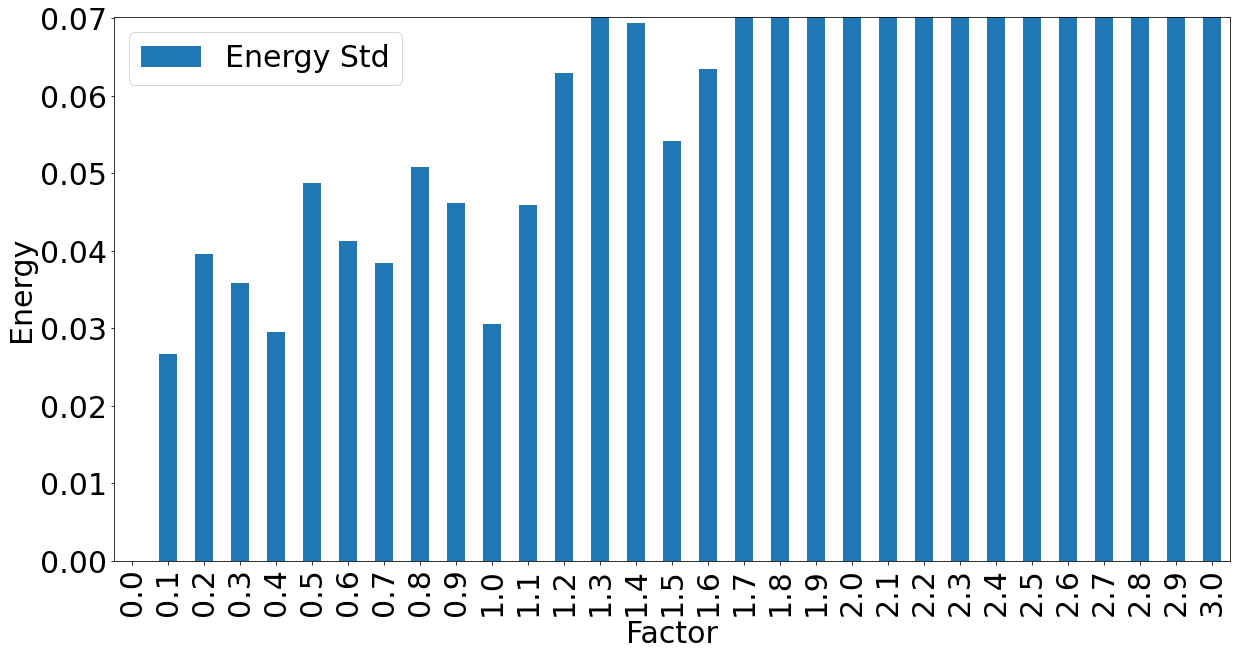

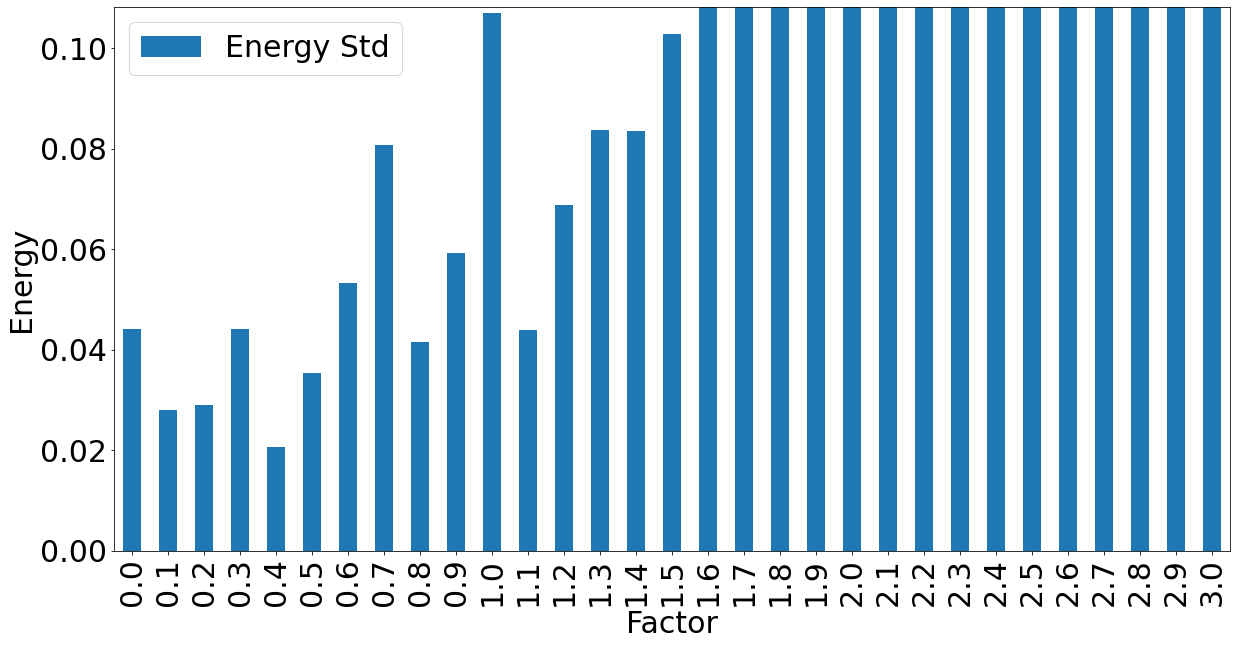

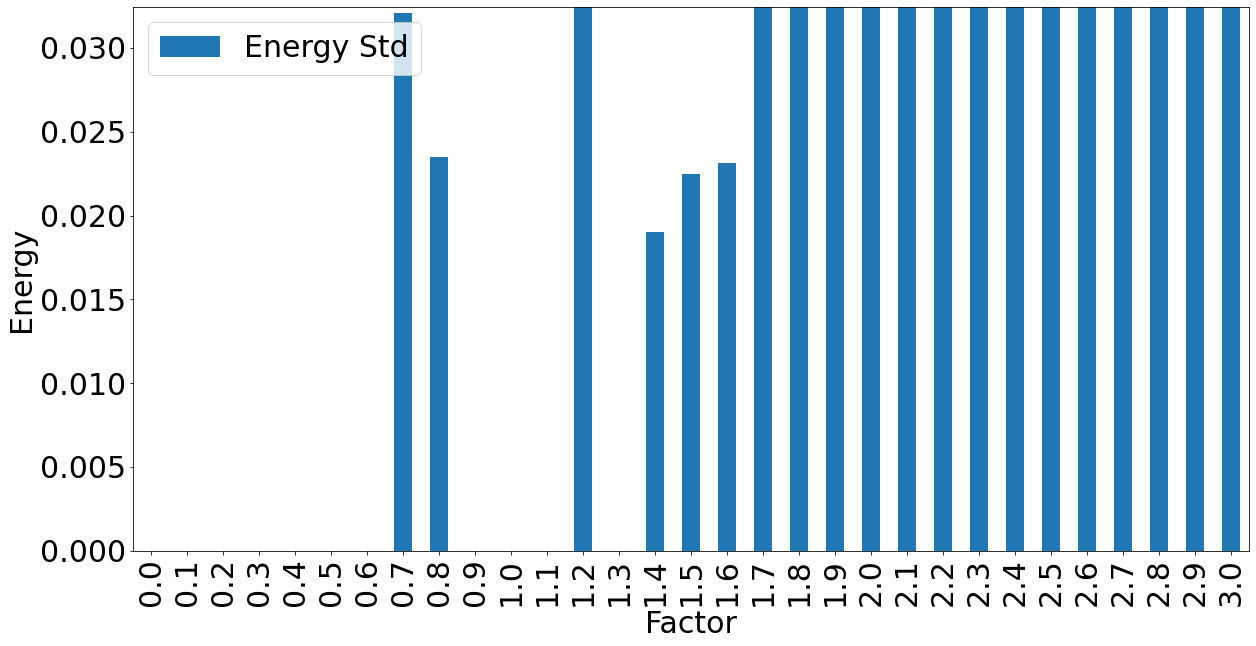

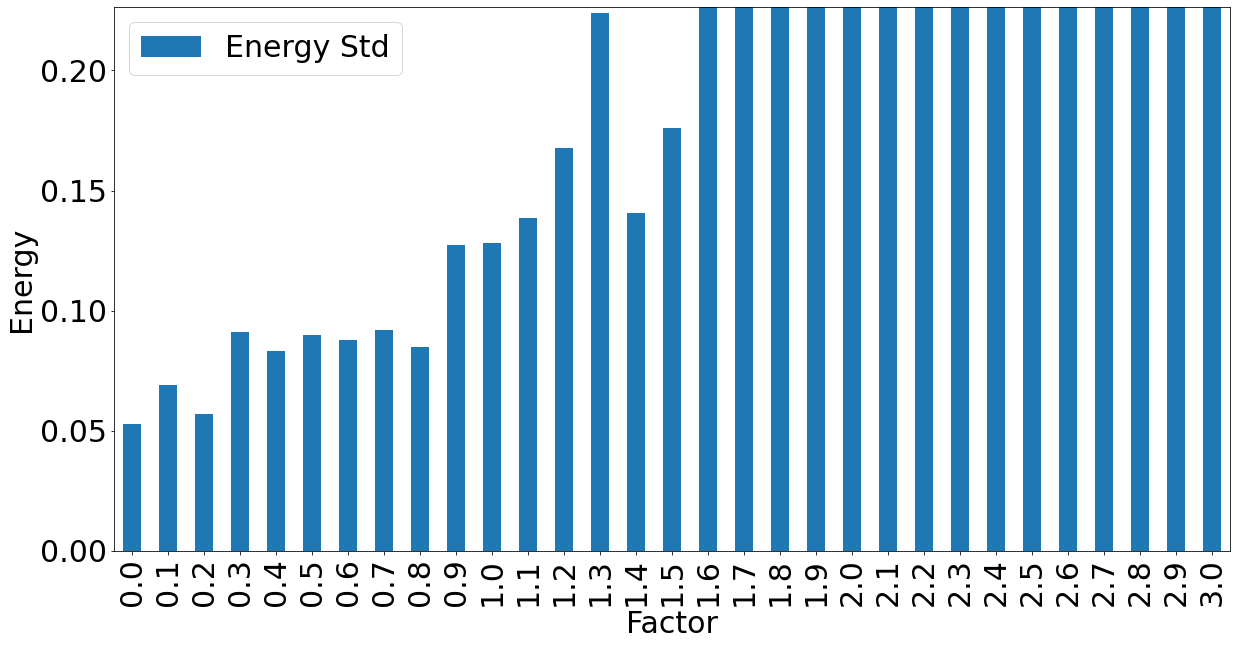

In [17]:
for name, group in factor_groups:
    ax = group.plot(kind='bar', y='Energy Std', figsize=(20,10))
    ax.set_ylim( top=group['Energy Std'].median()*1.01)
    ax.set_ylabel('Energy')
    ax.get_figure().savefig('Figures/Correlation_Test4_factors_lower_' + name, bbox_inches='tight')

Table of statistical data of the Measured-Value (Energy Std) divided by sample.

In [18]:
def get_data(name, group):
    s = group['Energy Std']
    g = s.agg(['mean','min','max']).rename(name.split('_')[-1])
    g['Initial'] = s.loc[0.0]
    return g

y = pd.DataFrame([get_data(name,group) for name, group in factor_groups])
y = y.rename(columns=str.capitalize)
y.index.set_names('Sample', inplace=True)
y.reset_index().to_latex('Tables/Correlation_increase.txt',float_format='{:.2f}'.format, caption='', label='')

Percentage increase of the evaluated-measure based on the factor divided by sample. Some graphs are empty because am increase cannot be calculated from a base value of 0.

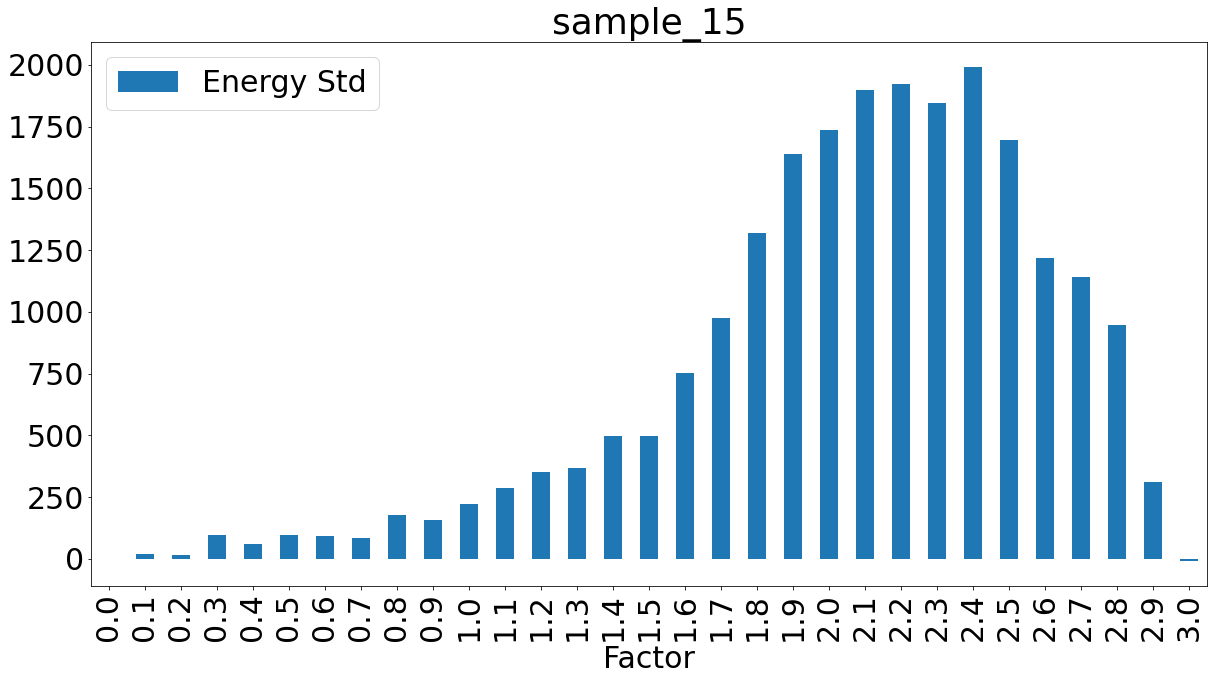

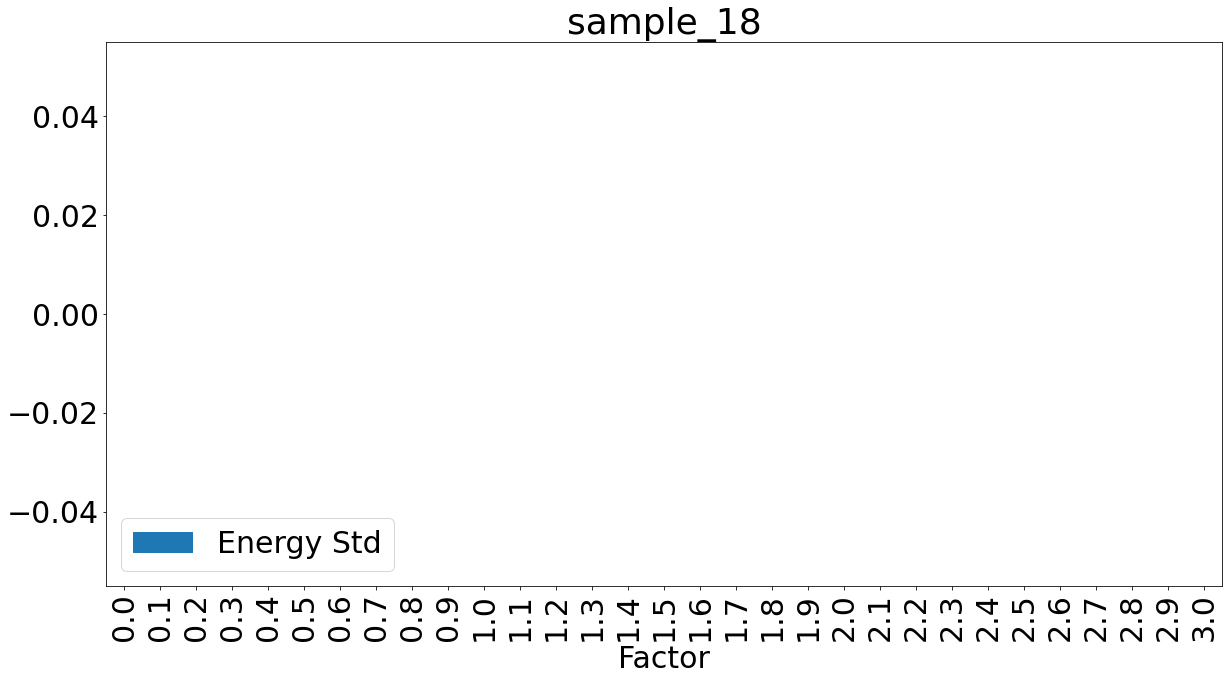

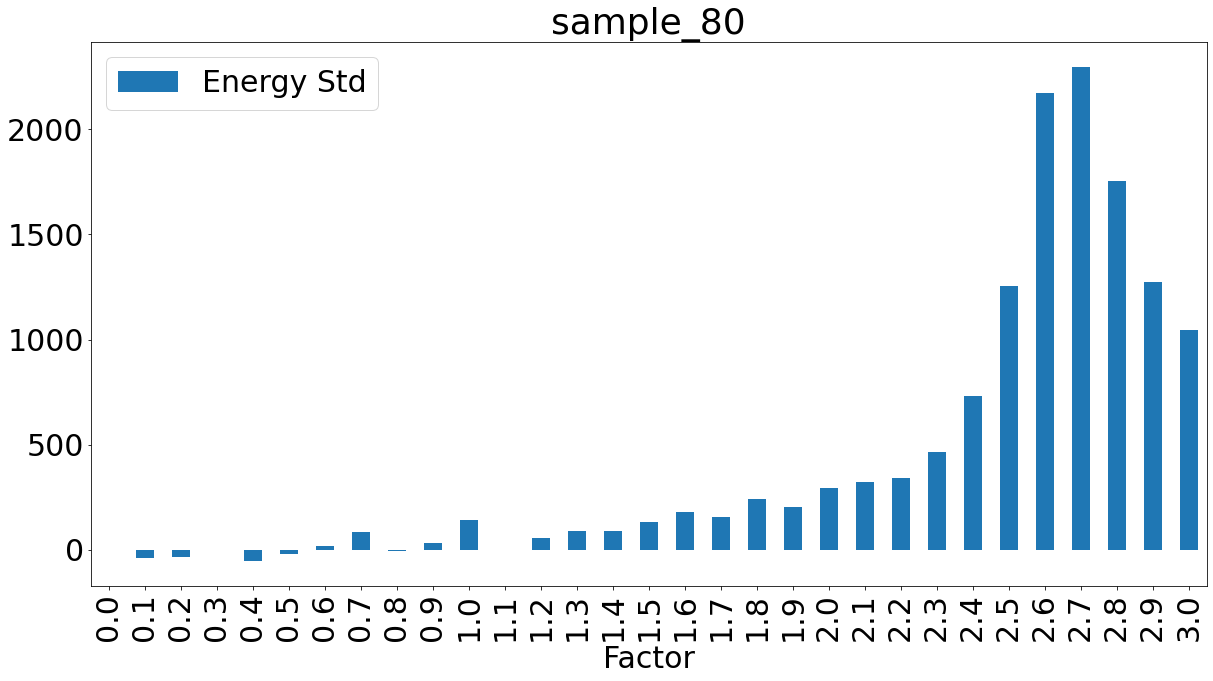

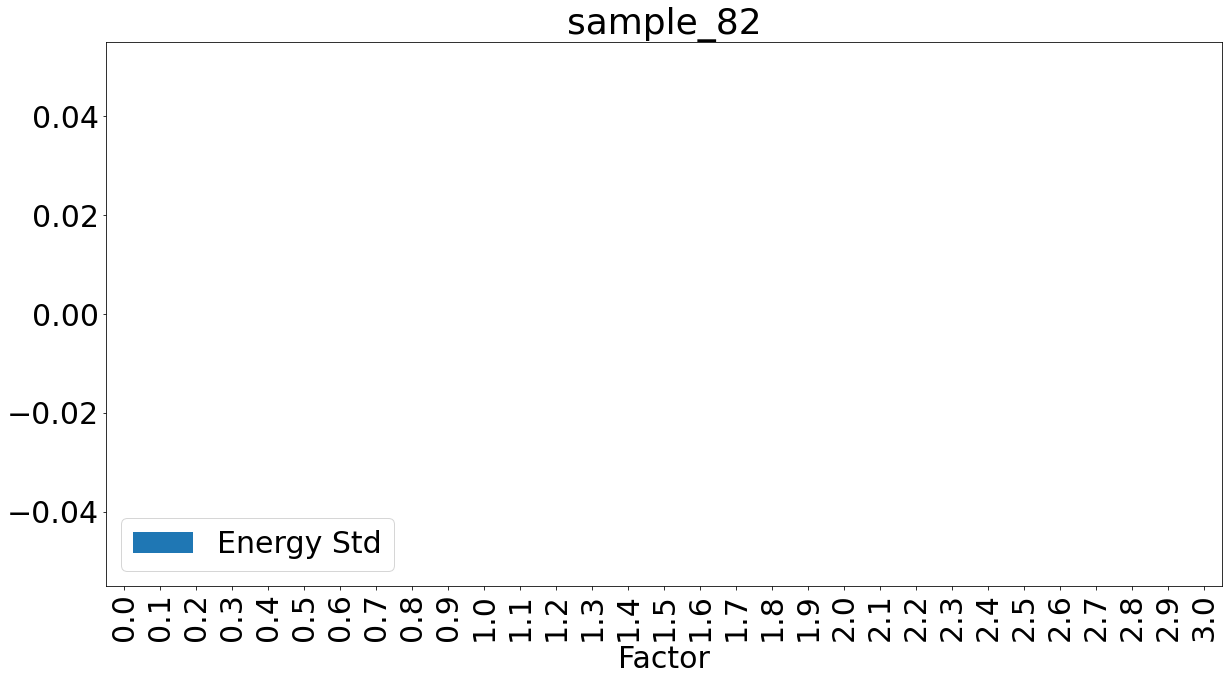

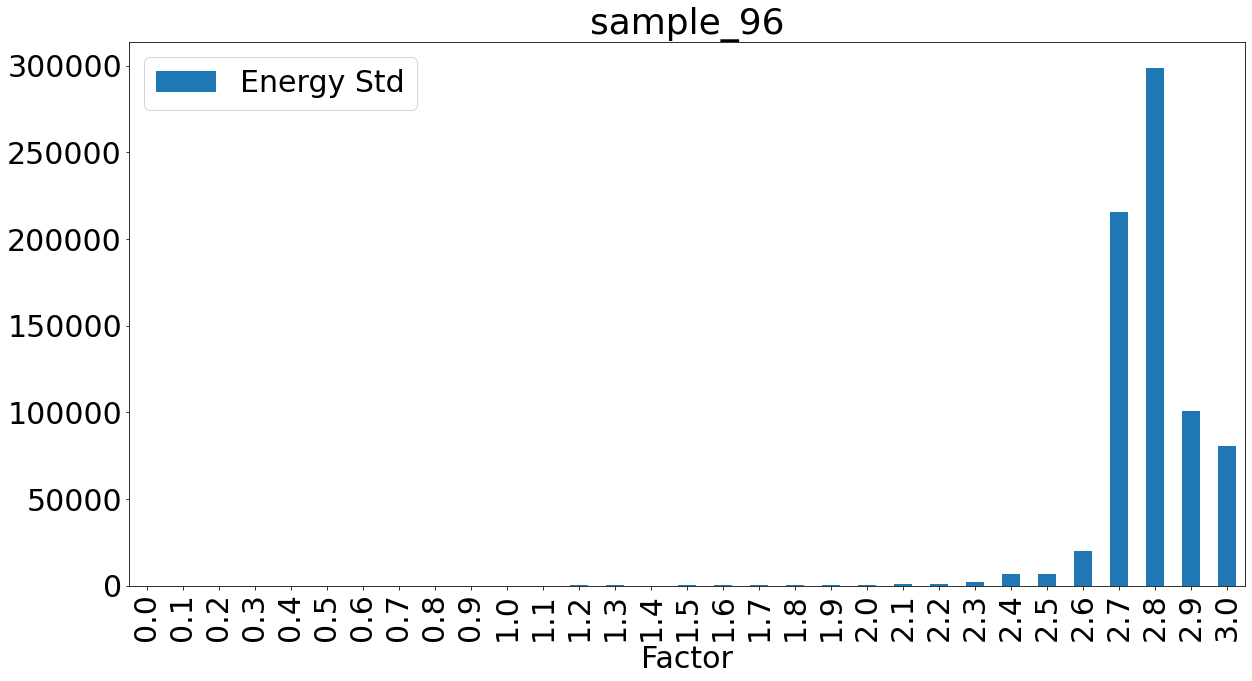

In [17]:
for name, group in factor_groups:
    ref_row = group.loc[0.0]
    group = group.apply(lambda x: 100/ref_row * x - 100, axis=1)
    group.plot(kind='bar', y='Energy Std', figsize=(20,10), title=name)



Development of the mean energy based on the relation between energy production and consumption.
See consumption rate section in the *SampleGeneration* Notebook for further information.

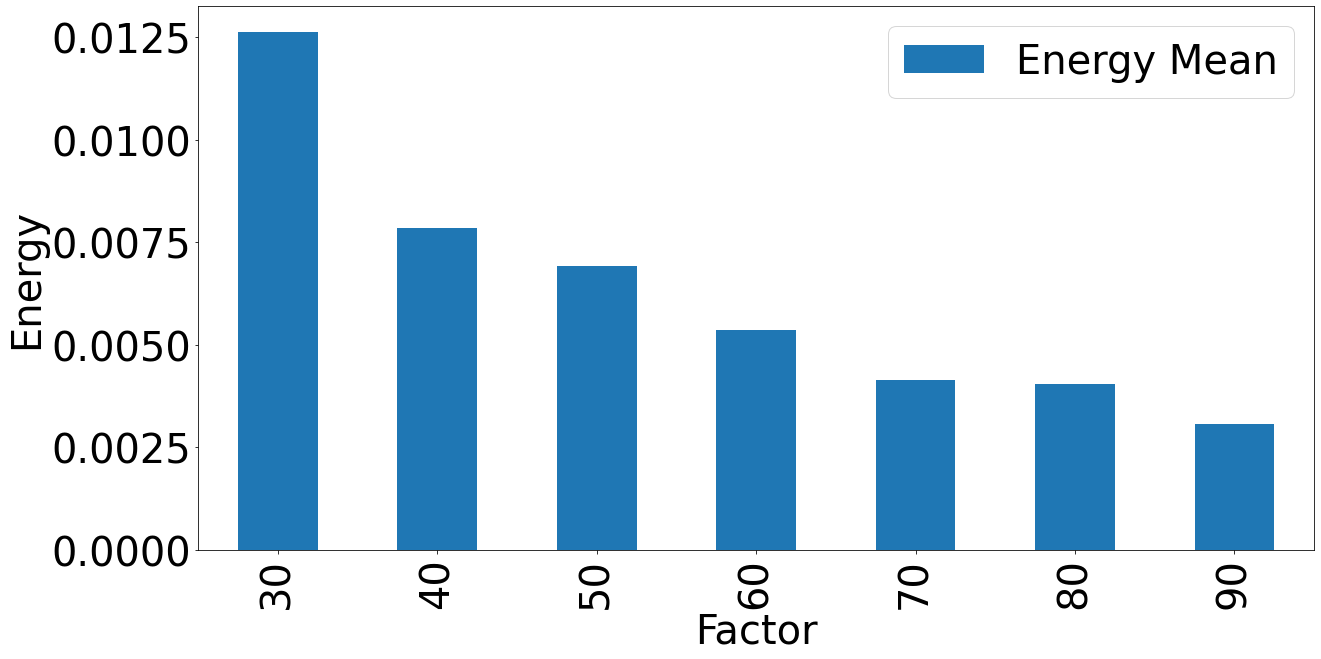

In [19]:
plt.rcParams['font.size'] = 40
df_ef = metadata_df.xs('20211013-232317')
df_ef[['Factor','Sample']] = df_ef.apply(lambda z: list(re.findall(r'\d+', z.name)), axis=1, result_type='expand')
df_ef['Sample'] = df_ef['Sample'].apply(lambda z: int(z)%50)
ax = df_ef.groupby('Factor')['Energy Mean'].mean()\
    .plot.bar(figsize=(20,10), ylabel='Energy',legend=True)
ax.get_figure().savefig('Figures/energy_factor.png', bbox_inches='tight' )

## Sensitivity analysis Plots##

In [20]:
def with_base_data(df):
    base_df = df.reset_index()[['Base Run','Base Sample']].drop_duplicates()
    base_df = metadata_df.loc[base_df.itertuples(index=False)].reset_index(level='Run Id')
    base_df.rename(columns={'Run Id':'Base Run'}, inplace=True)
    base_df['Base Sample'] = base_df.reset_index()['Sample Id'].values
    base_df['Factor'] = 1.0
    return pd.concat([df,base_df])

def extract_data_from_name(df):
    df['Factor'] = df.apply(lambda x: float((x.name.split('_')[-1]).strip('p'))/100, axis=1)
    df['Base Sample'] = df.apply(lambda x: '_'.join(x.name.split('_')[1:3]), axis=1)
    df['Base Run'] = df.apply(lambda x: x.name.split('_')[0], axis=1)
    df.sort_values(by=['Factor'], inplace=True)

### Sensitivity All ###
Mean energy in relation to the factor divided by sample.

array([[<AxesSubplot:title={'center':'sample_30-4'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'sample_30-45'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'sample_40-54'}, xlabel='Factor'>],
       [<AxesSubplot:title={'center':'sample_50-104'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'sample_50-145'}, xlabel='Factor'>,
        <AxesSubplot:xlabel='Factor'>]], dtype=object)

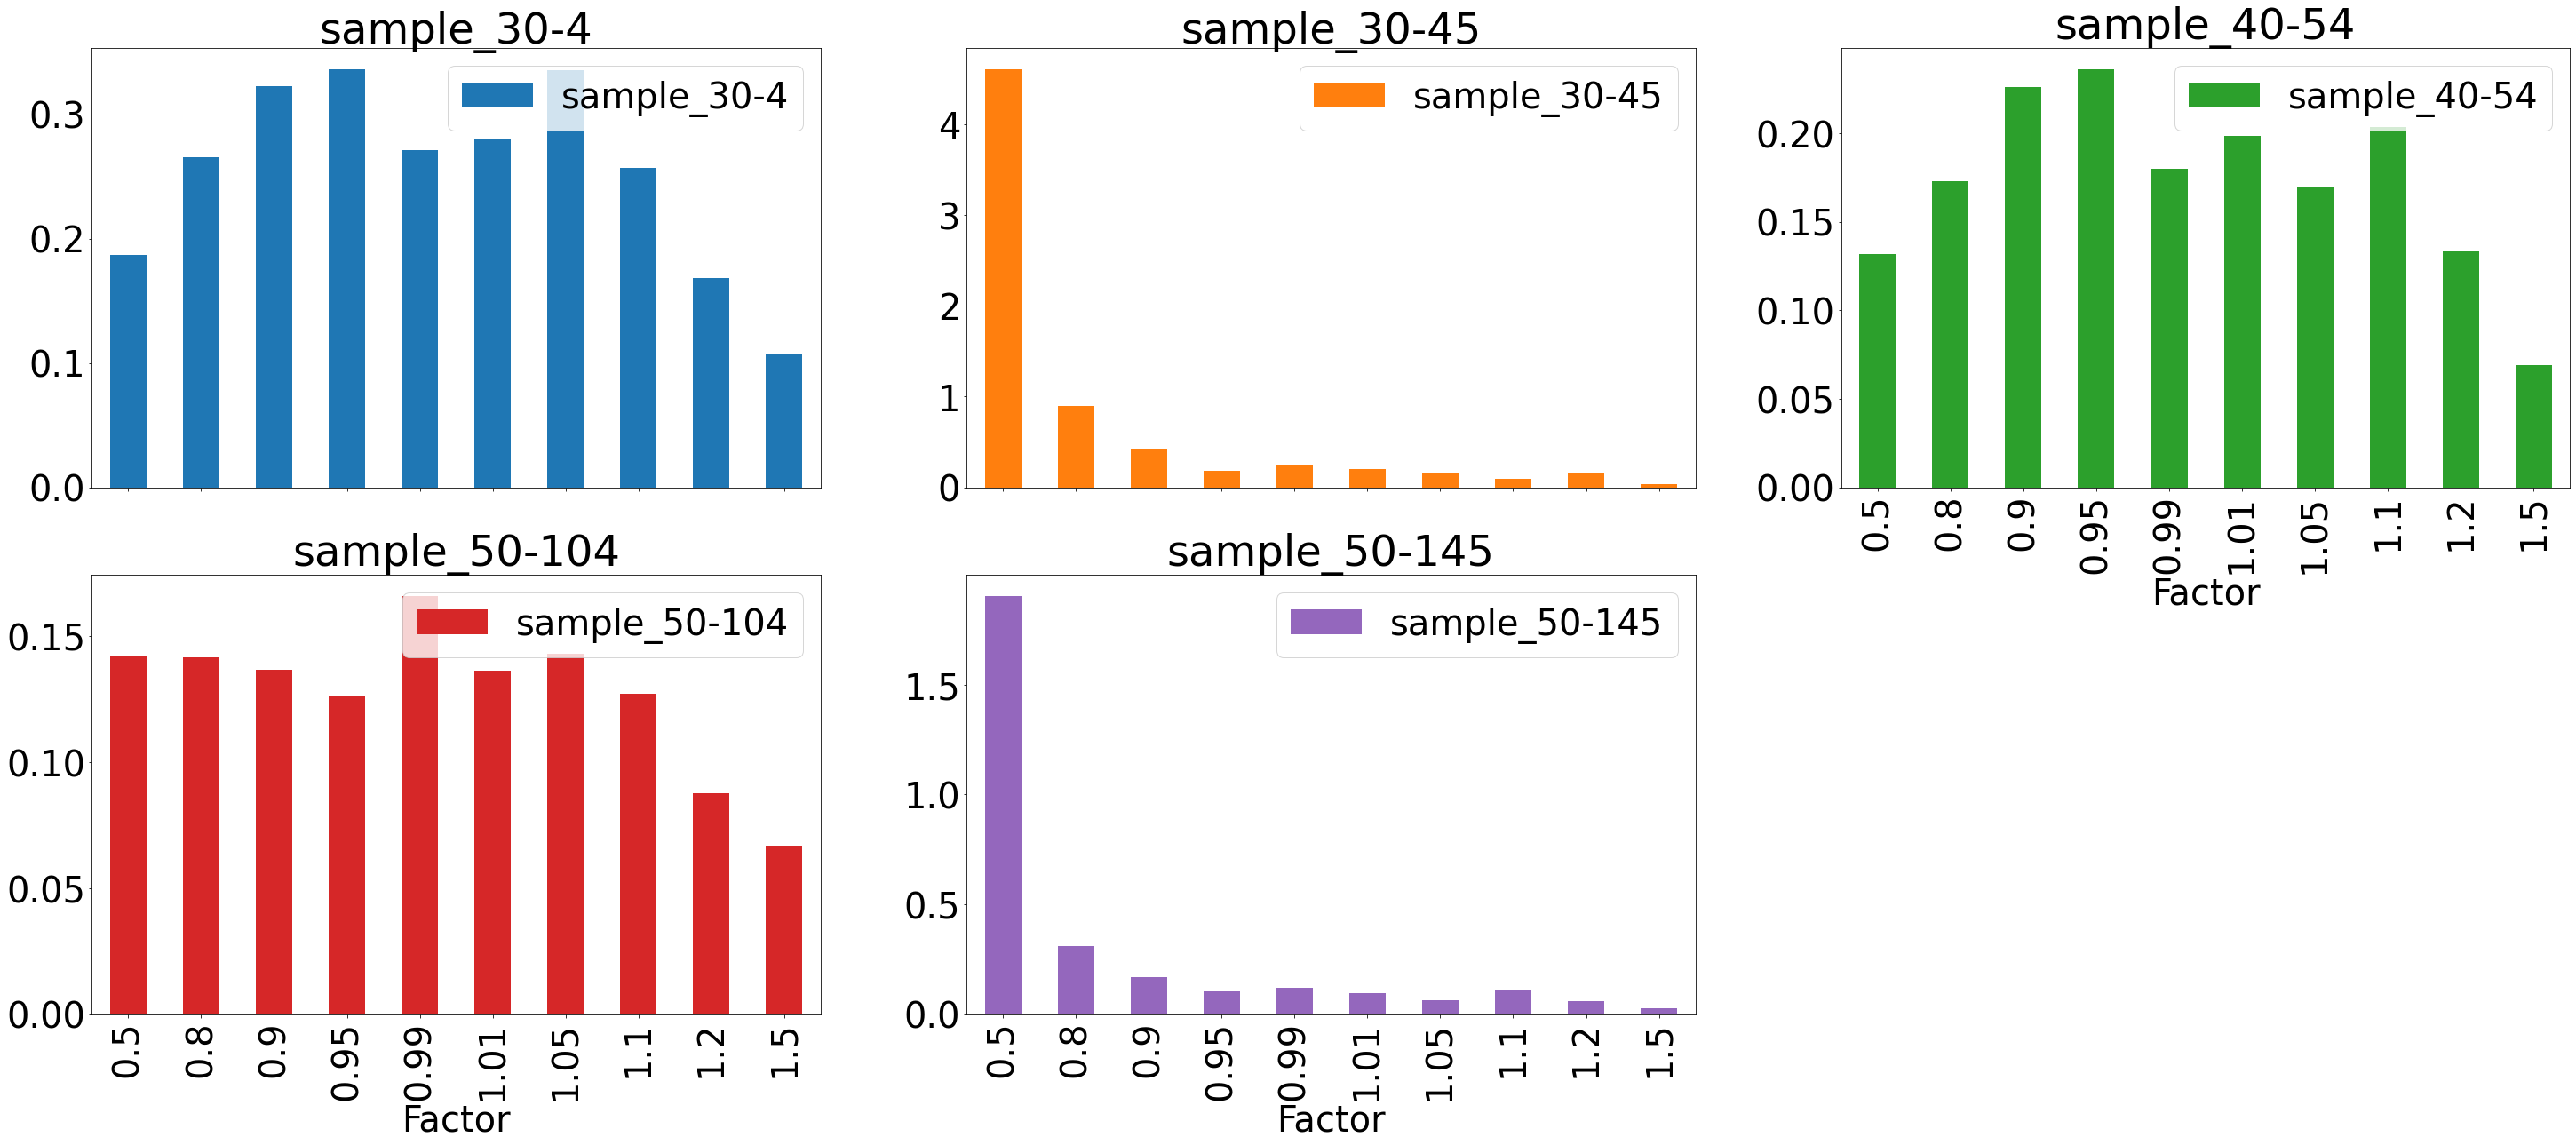

In [21]:
sensitivity_all = metadata_df.xs('Sensitivity_All_Run')
extract_data_from_name(sensitivity_all)
pd.pivot_table(sensitivity_all, index='Factor', columns='Base Sample').plot.bar(figsize=(50,20), y='Energy Mean', subplots=True, layout=(2,3))

Mean energy in relation to the factor divided by sample. Value of the base sample is included and marked with a different color.

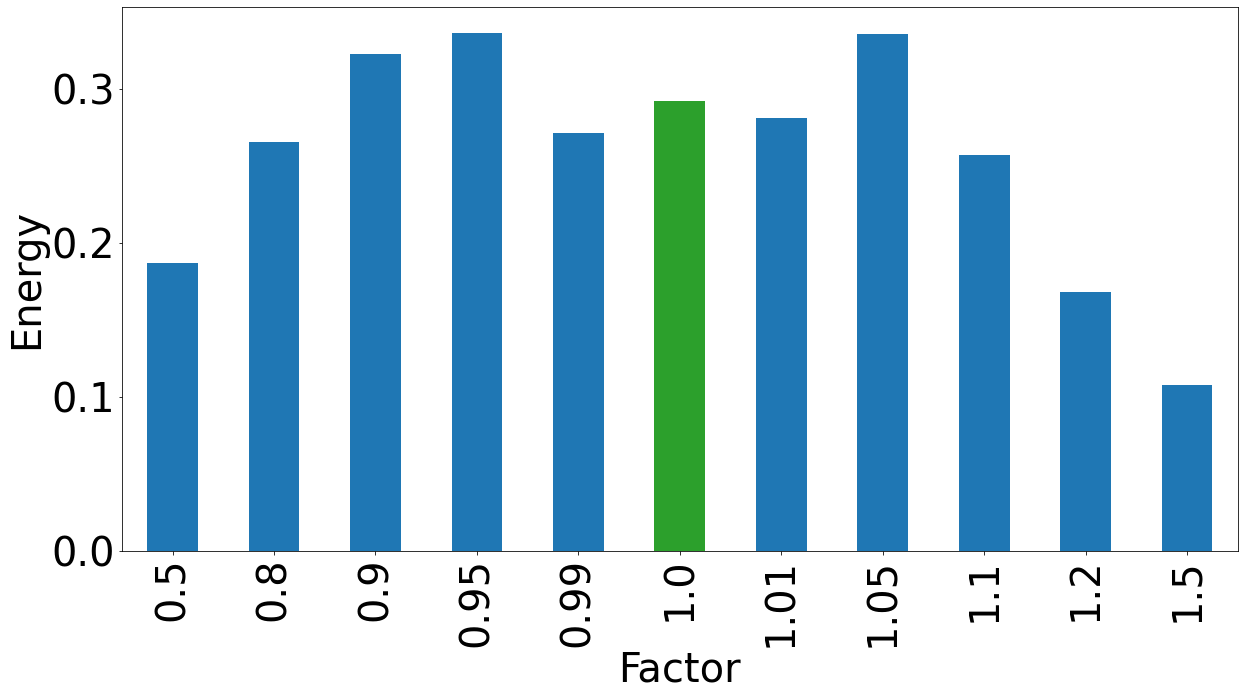

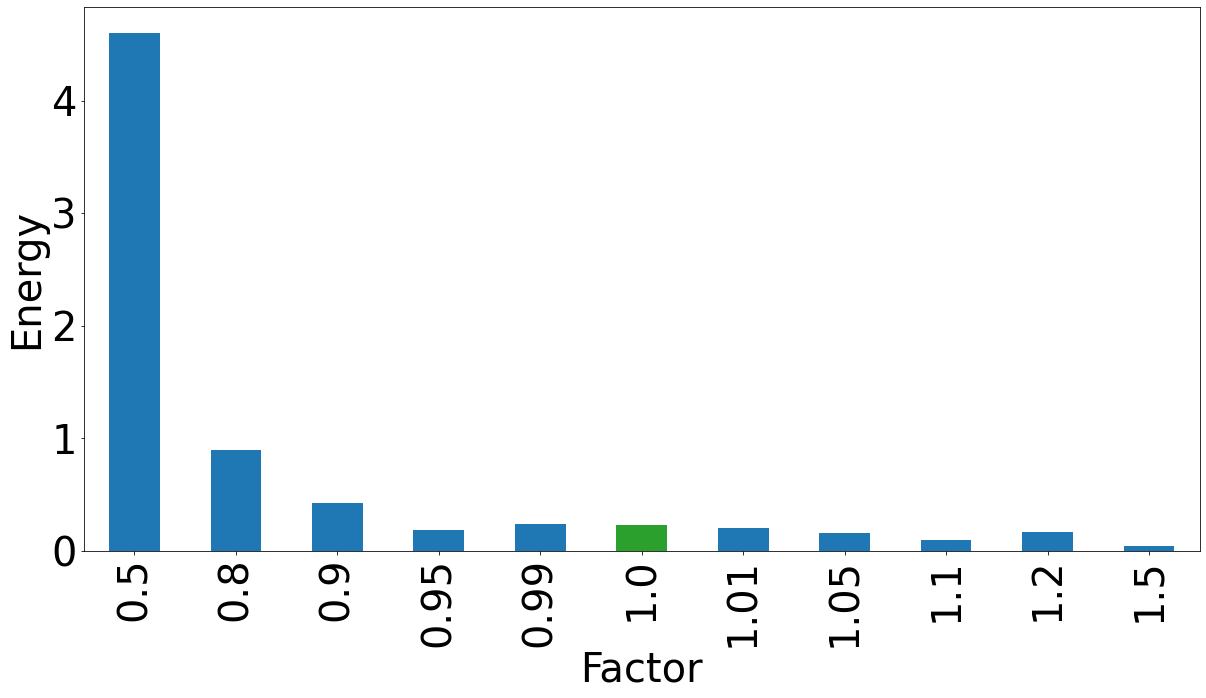

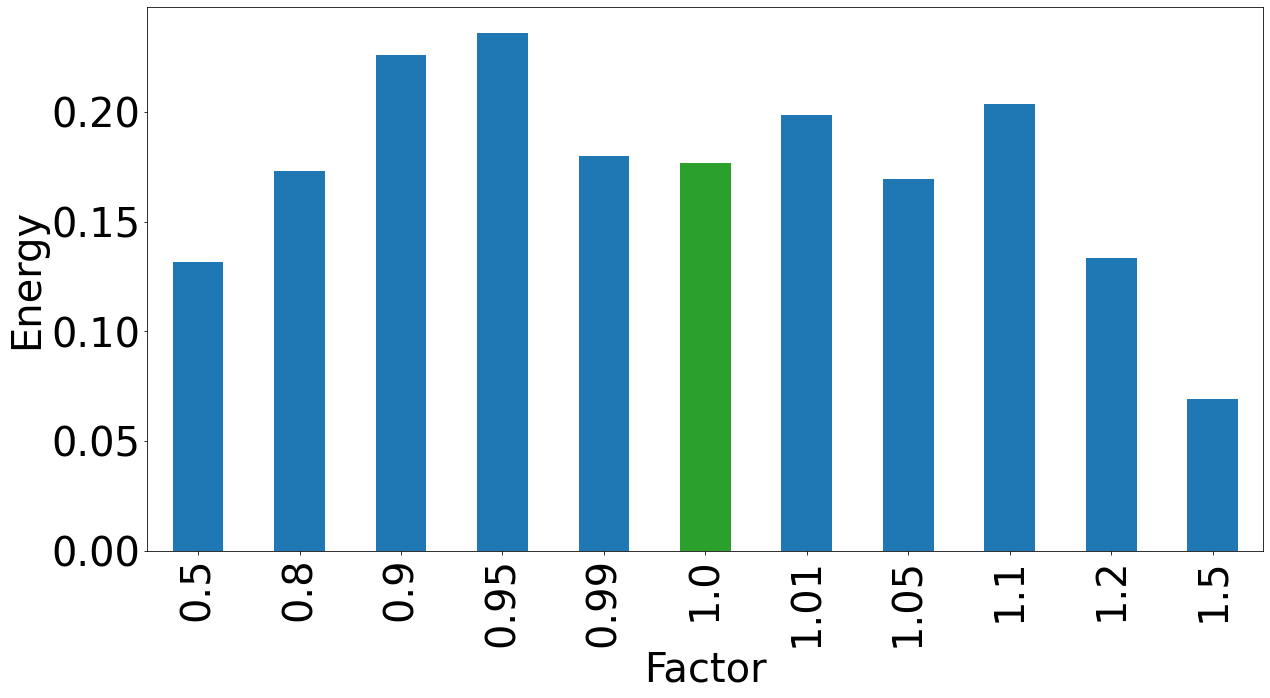

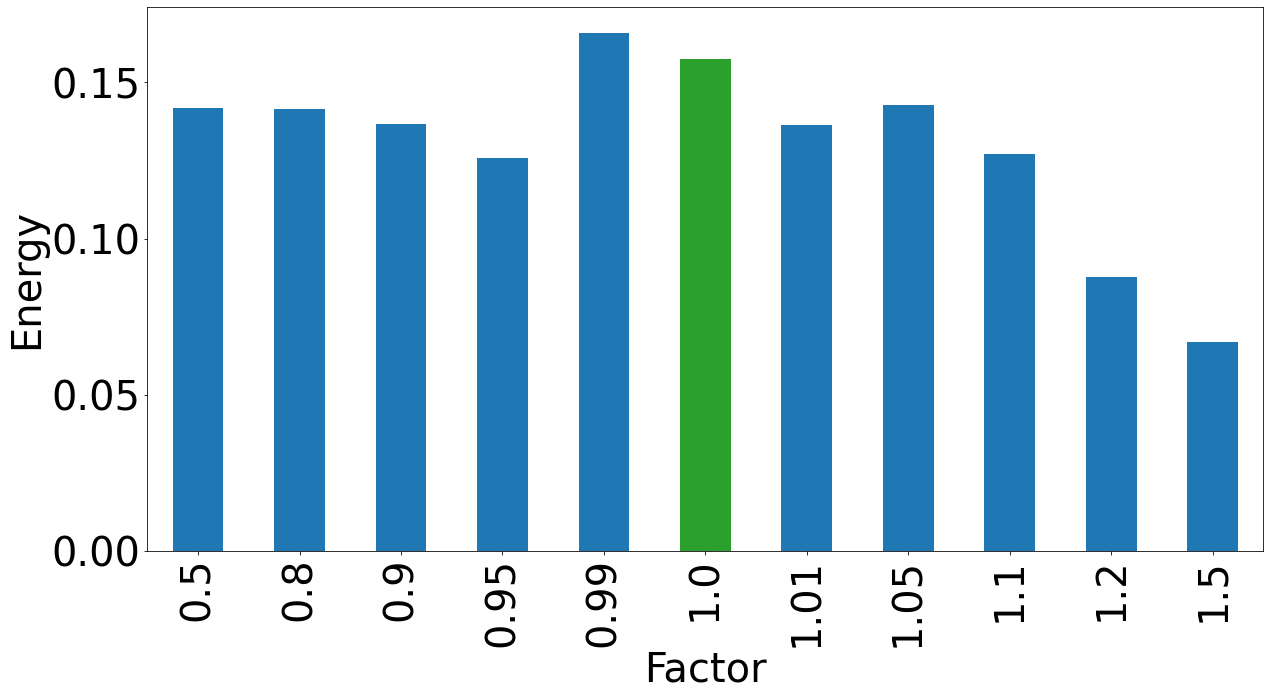

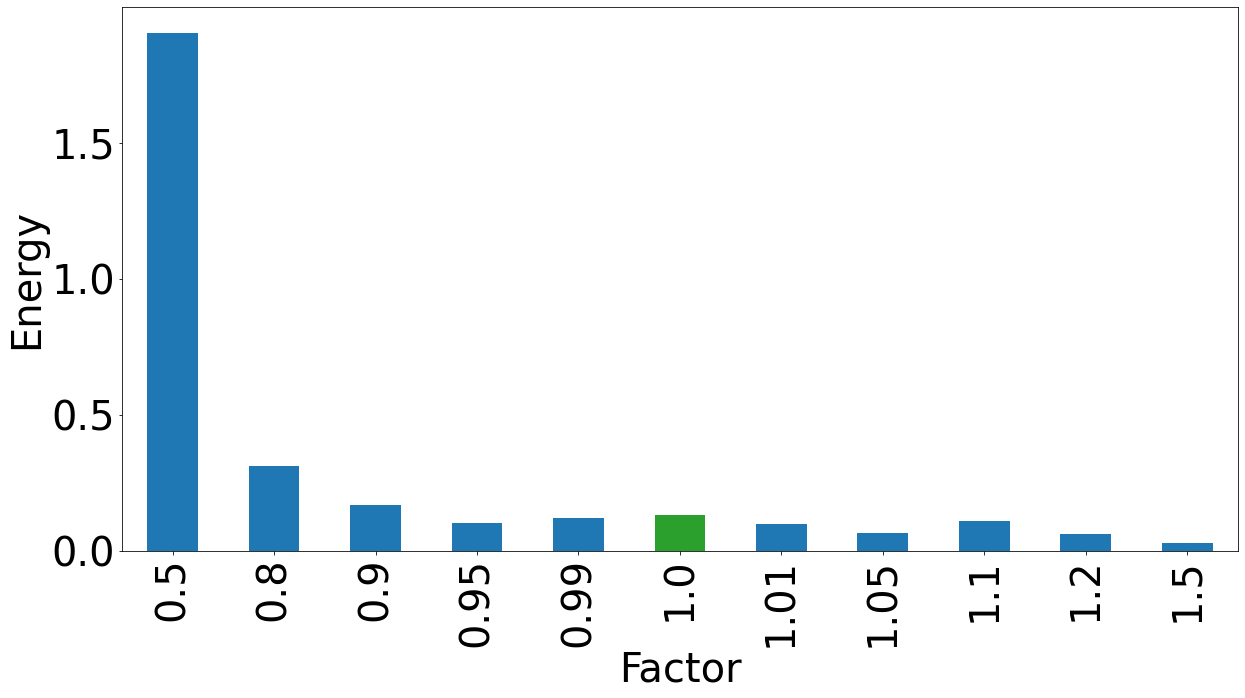

In [22]:
cmap = plt.get_cmap("tab10")
sensitivity_all2 = with_base_data(sensitivity_all).sort_values(['Base Sample','Factor'])
bar_colors = list(map(lambda x: cmap(2) if x == 1.0 else cmap(0) ,np.sort(sensitivity_all2['Factor'].unique())))
for name, group in sensitivity_all2.groupby('Base Sample'):
    ax = group.plot.bar(x='Factor', y='Energy Mean',figsize=(20,10), color=bar_colors, legend=False)
    ax.set_ylabel('Energy')
    ax.get_figure().savefig('Figures/sensitivity_all/'+name+'.png', bbox_inches='tight')

### Sensitivity Single ###
Mean energy in relation to the factor divided by sample.

array([[<AxesSubplot:title={'center':'EnergyLoss'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'LinearForceMax'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'Mass'}, xlabel='Factor'>],
       [<AxesSubplot:title={'center':'RotationForceMax'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'RotationVelocityMax'}, xlabel='Factor'>,
        <AxesSubplot:title={'center':'VelocityMax'}, xlabel='Factor'>]],
      dtype=object)

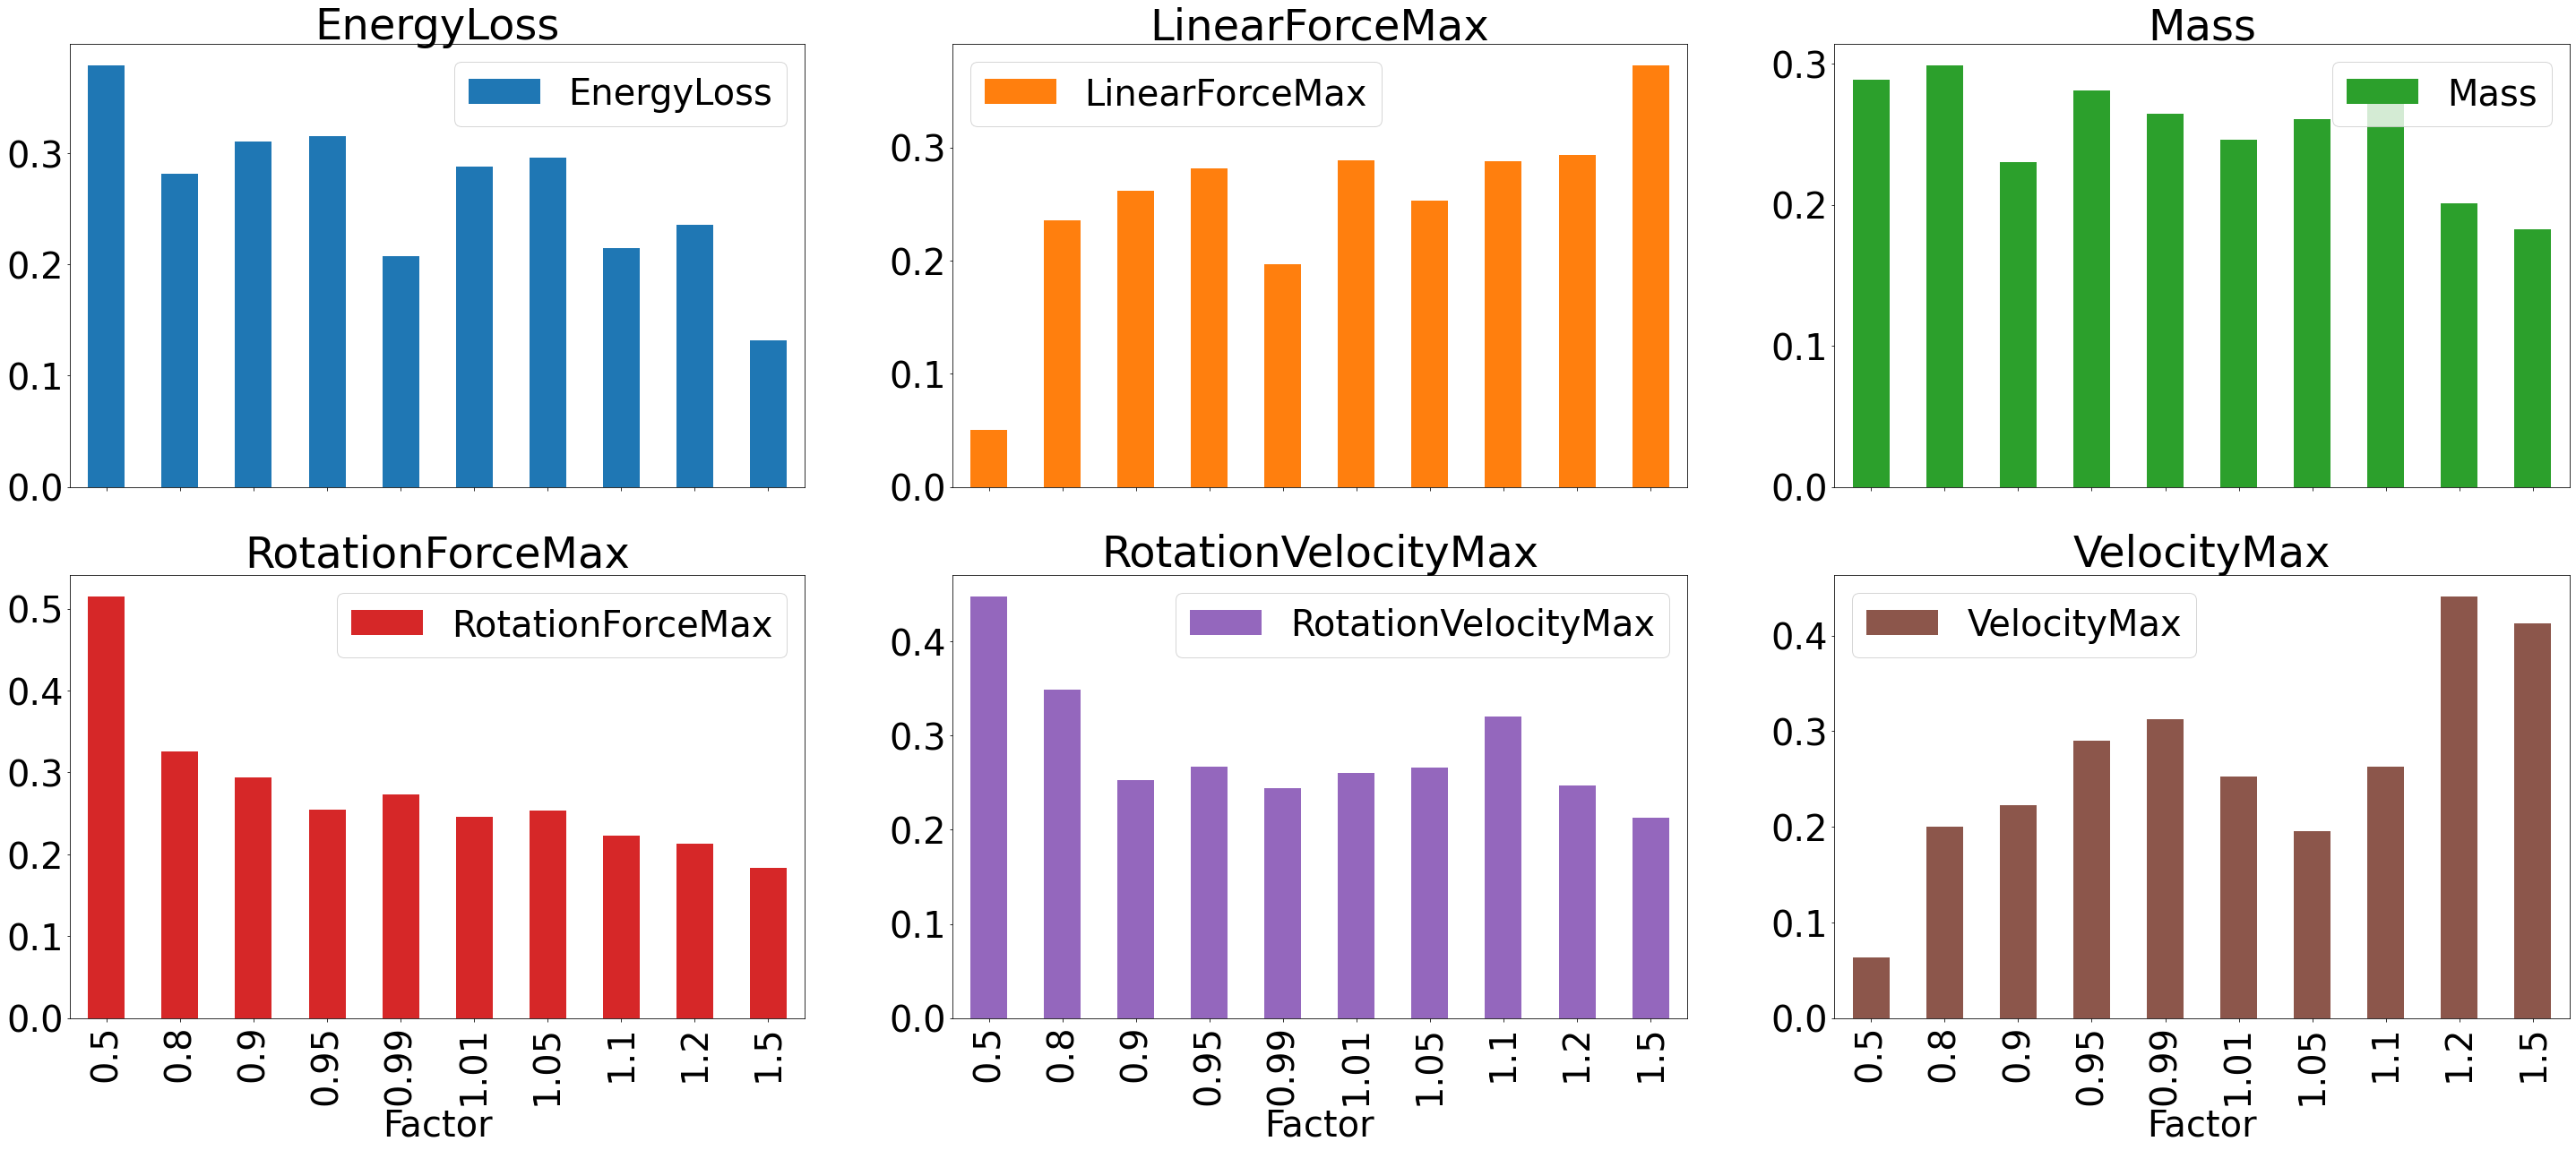

In [23]:
sensitivity_single = metadata_df.xs('Sensitivity_Single_Run')
extract_data_from_name(sensitivity_single)
sensitivity_single['Parameter'] = sensitivity_single\
    .apply(lambda x: x.name.split('_')[3], axis=1)

pd.pivot_table(sensitivity_single, index='Factor', columns='Parameter')\
    .plot.bar(figsize=(50,20), y='Energy Mean', subplots=True, layout=(2,3))

Mean energy in relation to the factor divided by sample. Value of the base sample is included and marked with a different color.

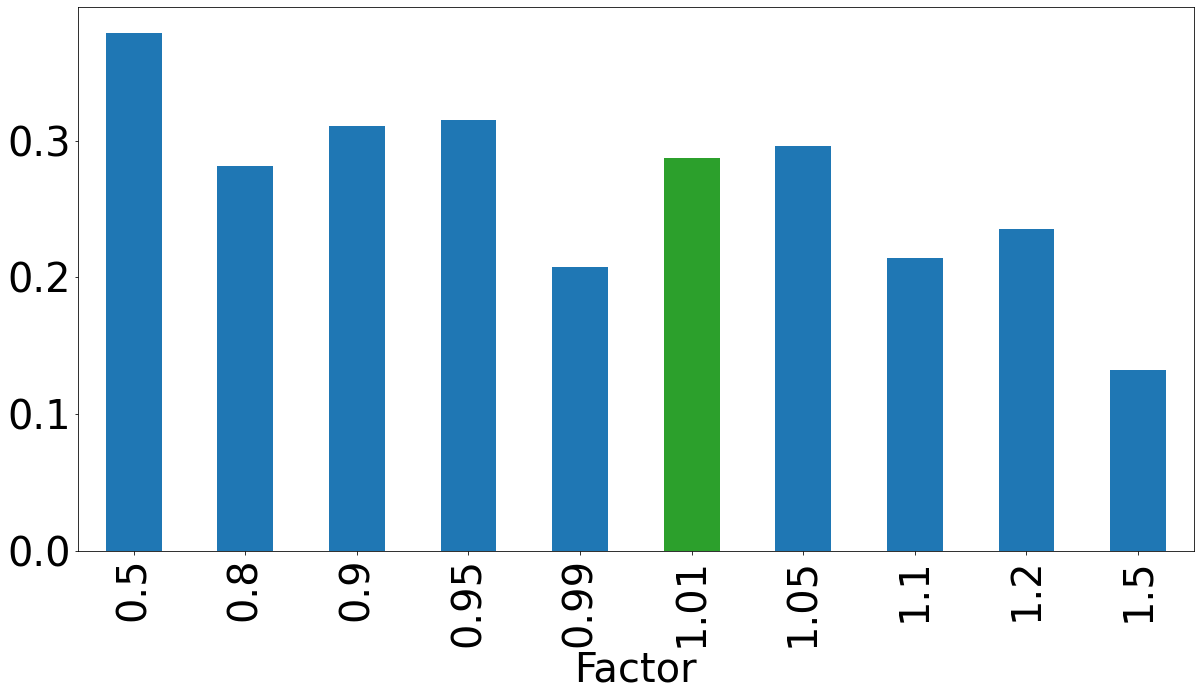

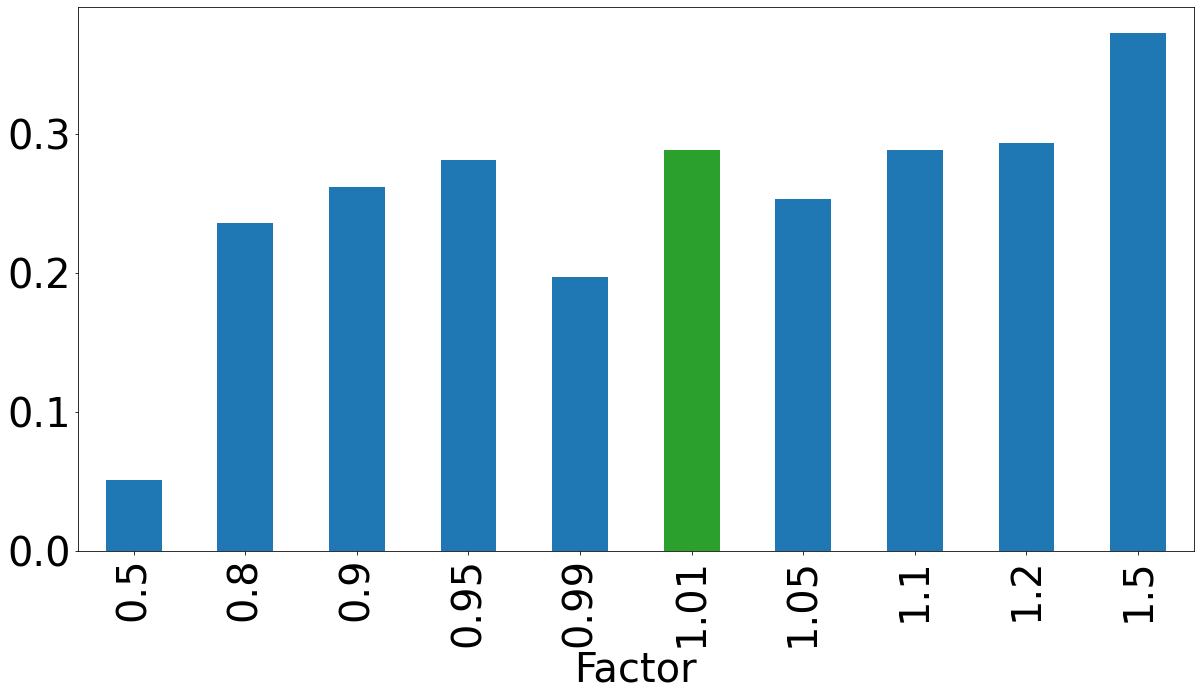

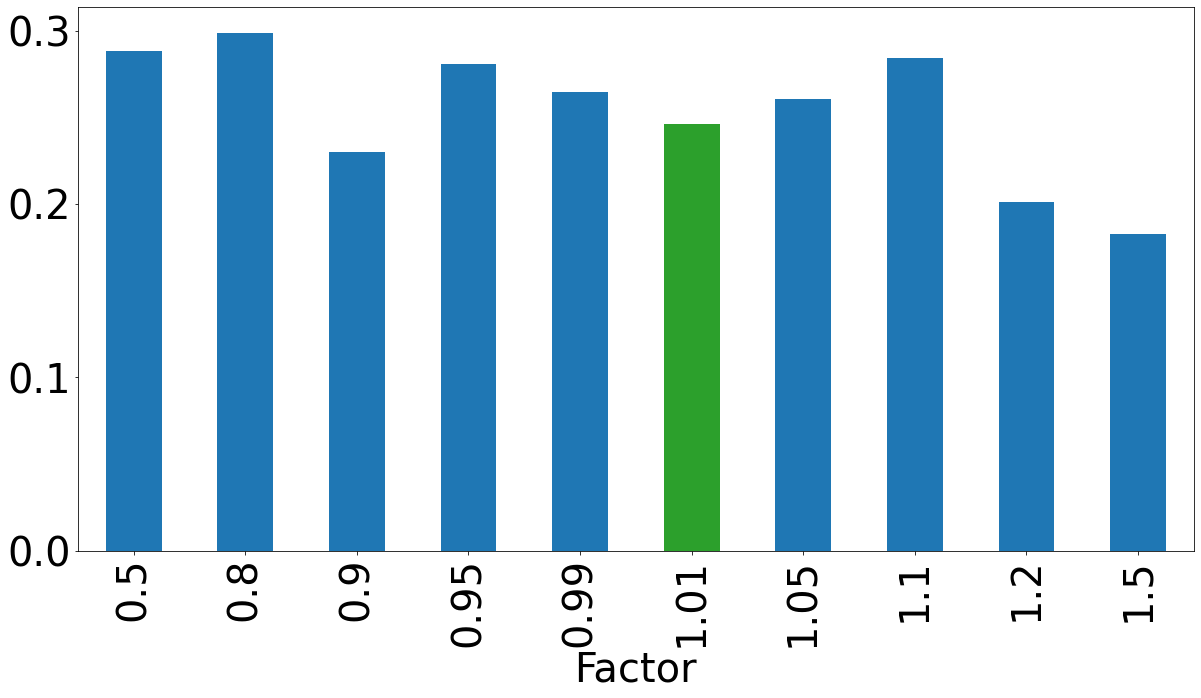

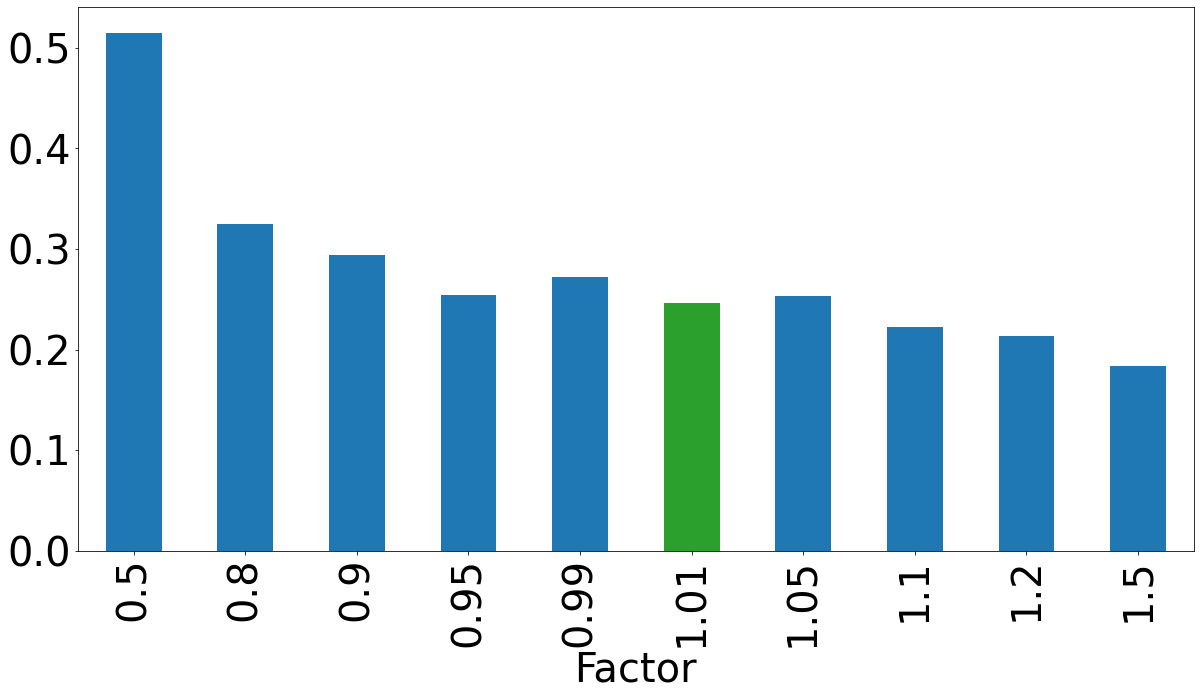

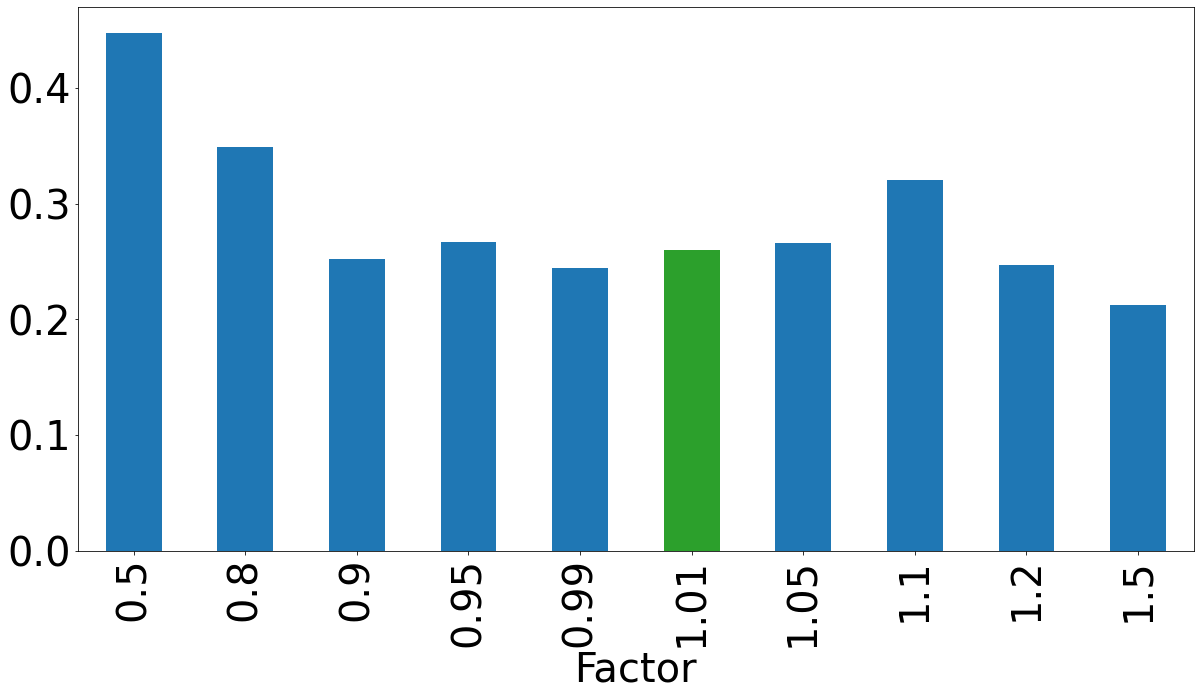

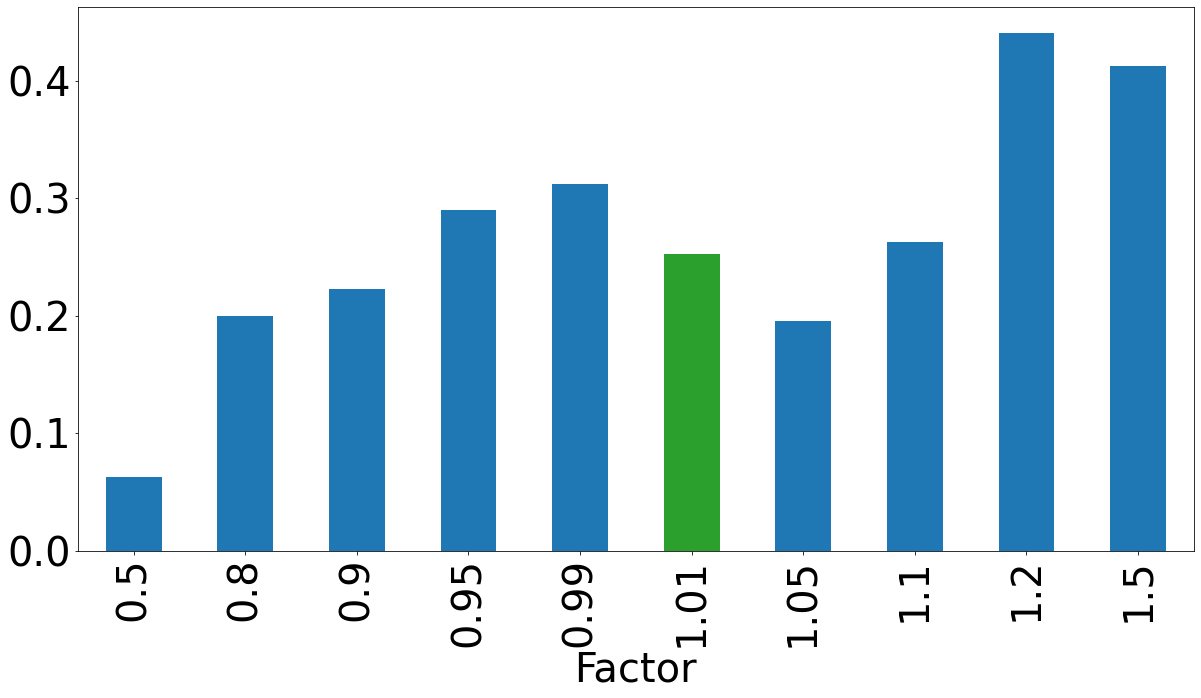

In [24]:
sensitivity_single2 = with_base_data(sensitivity_single).sort_values(['Base Sample','Factor'])
for name, group in sensitivity_single2.groupby('Parameter'):
    ax = group.plot.bar(x='Factor', y='Energy Mean',figsize=(20,10), color=bar_colors, legend=False)
    ax.get_figure().savefig('Figures/sensitivity_single/'+name+'.png', bbox_inches='tight')

### Sensitivity Combination ###
Extracting additional information from the sample files (not the data) and calculating some additional metadata.

In [20]:
config_path = 'Samples/Sensitivity_Combination_Run'
config_parameters = ['[3].Modified_Values', '[3].Modified_Percentage']

def get_data(series, parameters, config_directory):
    return utility.get_json_values(utility.get_config(path.join(config_directory, series.name + '.json')), parameters)

def get_ids(series):
    parts = series.name.split('_')
    return parts[0], '_'.join(parts[1:-1]), parts[-1]

sensitivity_combination = metadata_df.xs('Sensitivity_Combination_Run')

sensitivity_combination[['Source Run', 'Source Sample', 'Sample Number']] = sensitivity_combination.apply(get_ids, axis=1, result_type='expand')
sensitivity_combination = sensitivity_combination.join(sensitivity_combination.apply(functools.partial(get_data, config_directory=config_path, parameters=config_parameters), axis=1, result_type='expand'))
sensitivity_combination.rename(columns={
    'Modified_Percentage': 'Factor',
    'Modified_Values': 'Modified Values'
    }, inplace=True)
sensitivity_combination.set_index(['Source Run', 'Source Sample'], inplace=True)
sensitivity_combination['Modified Count'] = sensitivity_combination['Modified Values'].apply(len)
sensitivity_combination['Modified Values Str'] = sensitivity_combination['Modified Values'].apply(str)

source_data = [metadata_df.loc[sensitivity_combination.index.unique()]]
value_groups = [group['Modified Values'][0] for name, group in sensitivity_combination.groupby(['Modified Values Str'])]
source_df2 = pd.concat([*source_data]*len(value_groups))
source_df2['Modified Values'] = value_groups
source_df2['Factor'] = 1
source_df2['Modified Count'] = source_df2['Modified Values'].apply(len)
source_df2['Modified Values Str'] = source_df2['Modified Values'].apply(str)

sensitivity_combination_all = pd.concat([sensitivity_combination,source_df2])
sensitivity_combination_all.sort_values(by=['Modified Values Str','Factor'], inplace=True)

Energy development in relation to the factor. Values are separated based on the number of modified values.

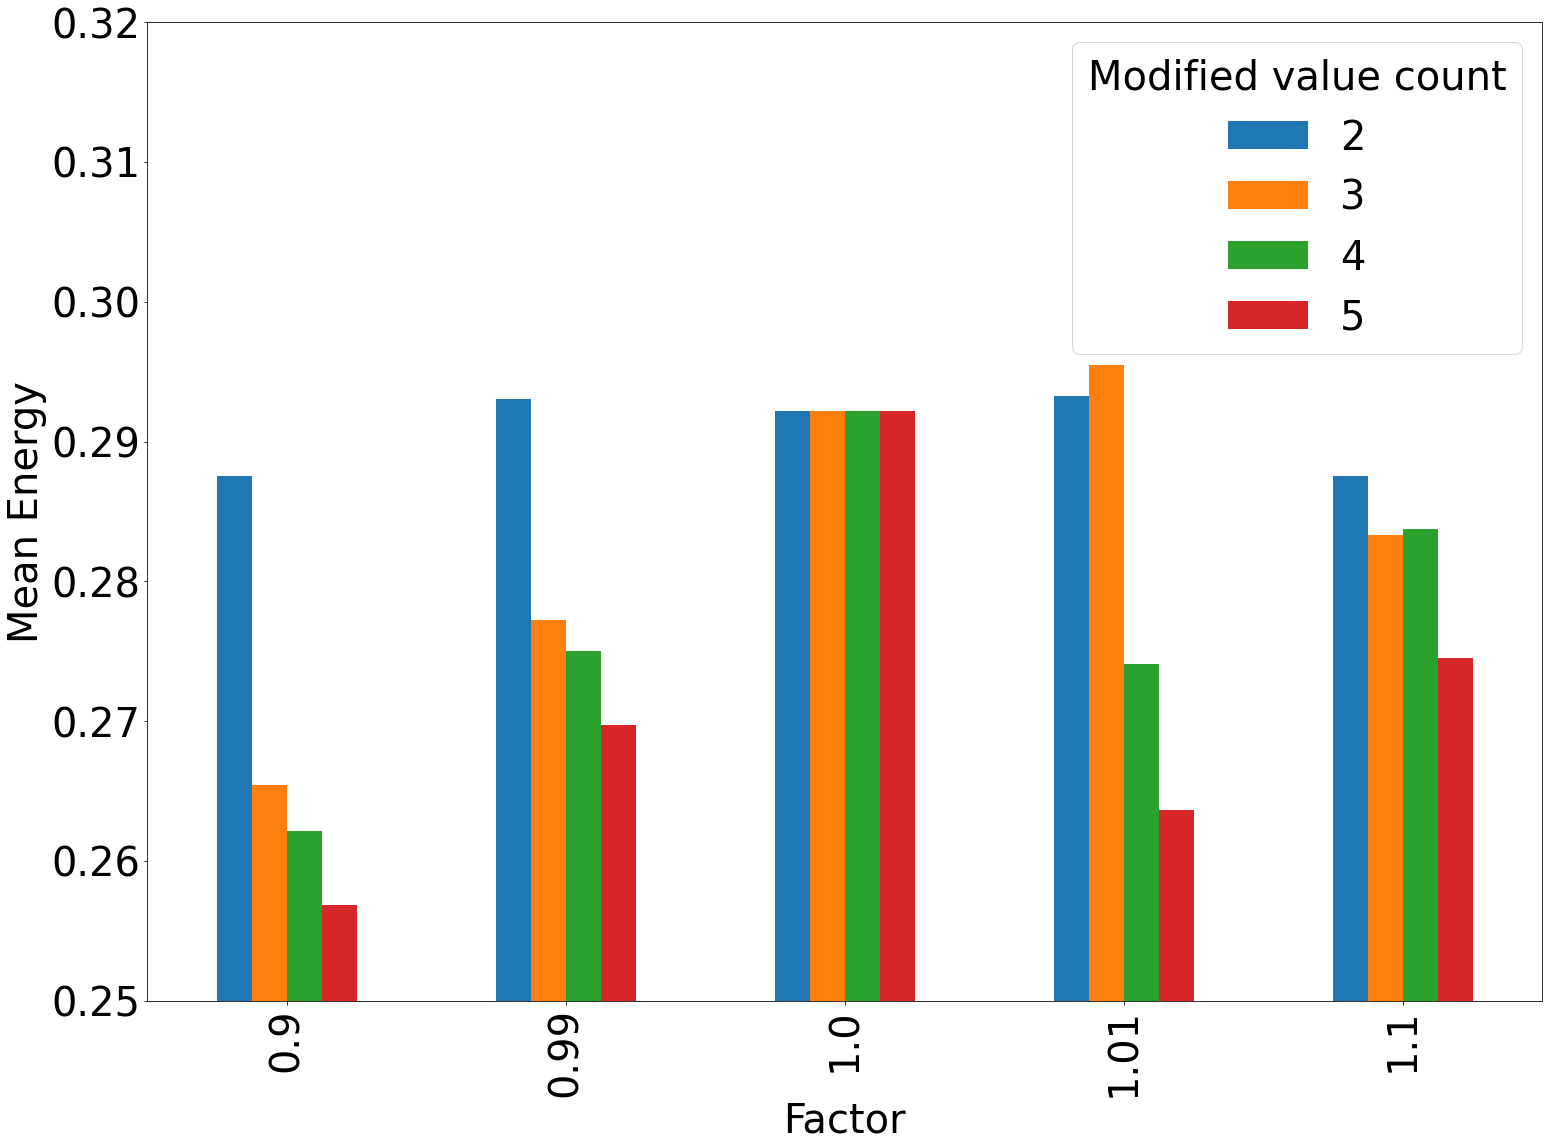

In [27]:
ax = pd.pivot_table(sensitivity_combination_all, index='Factor', columns='Modified Count')\
    .plot.bar(figsize=(25,18), y='Energy Mean', sharey=True)
ax.set_ylabel('Mean Energy')
ax.set_ylim(bottom=0.25, top=0.32)
plt.legend(loc='upper right', title='Modified value count')
ax.get_figure().savefig('Figures/sensitivity_combination')

Energy development in relation to the factor. Values are separated based on the number of modified values. Each graph contains all samples that have the mentionted parameter modified.

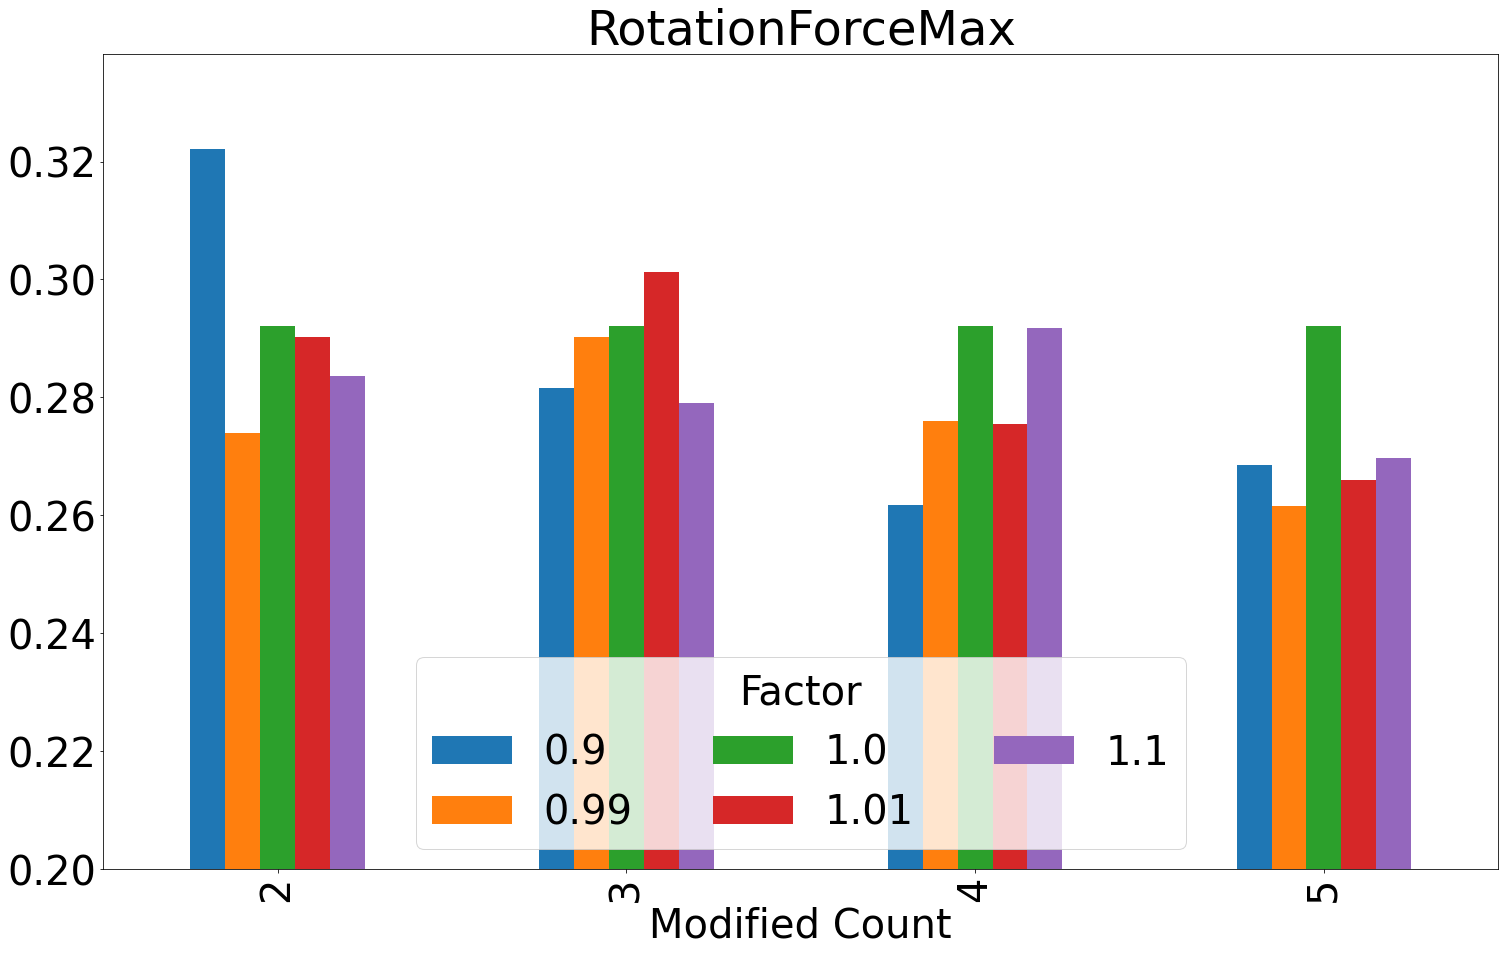

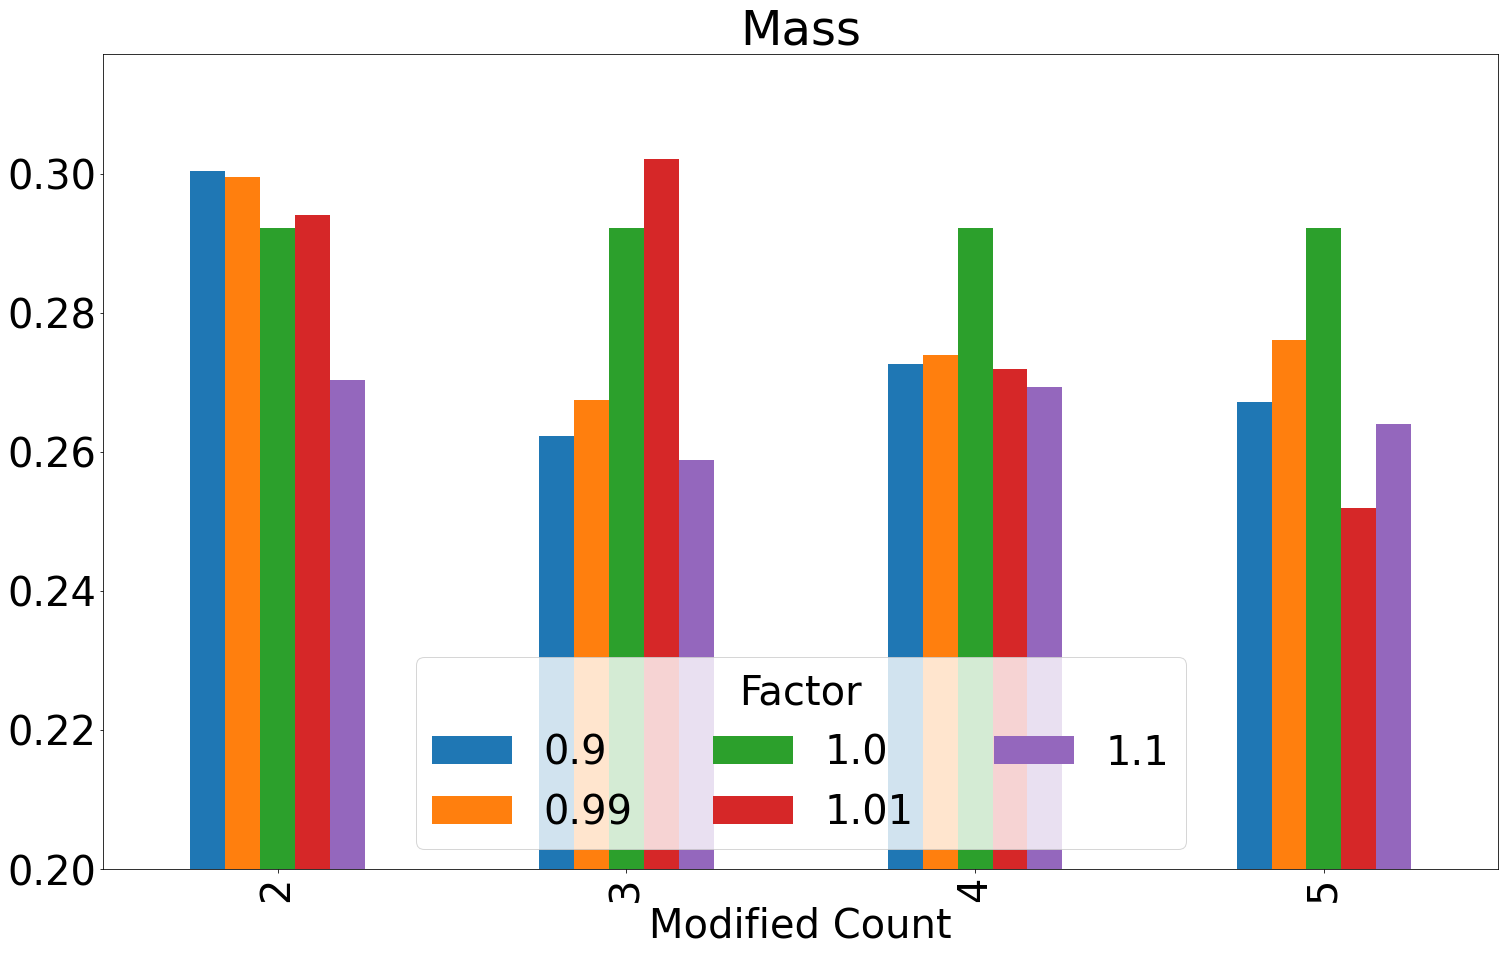

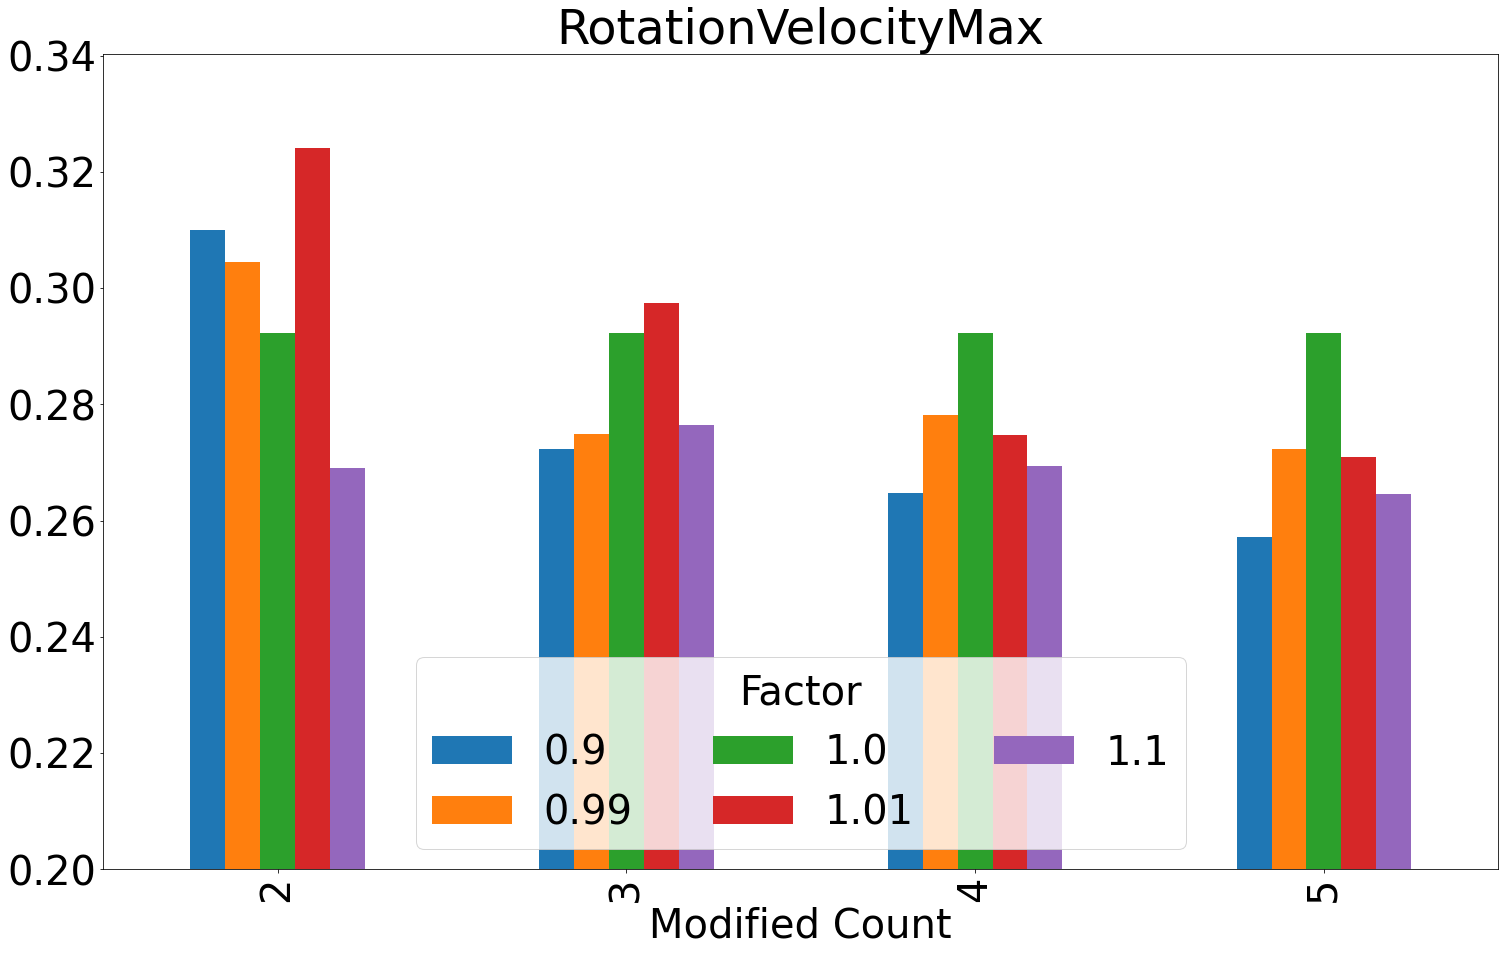

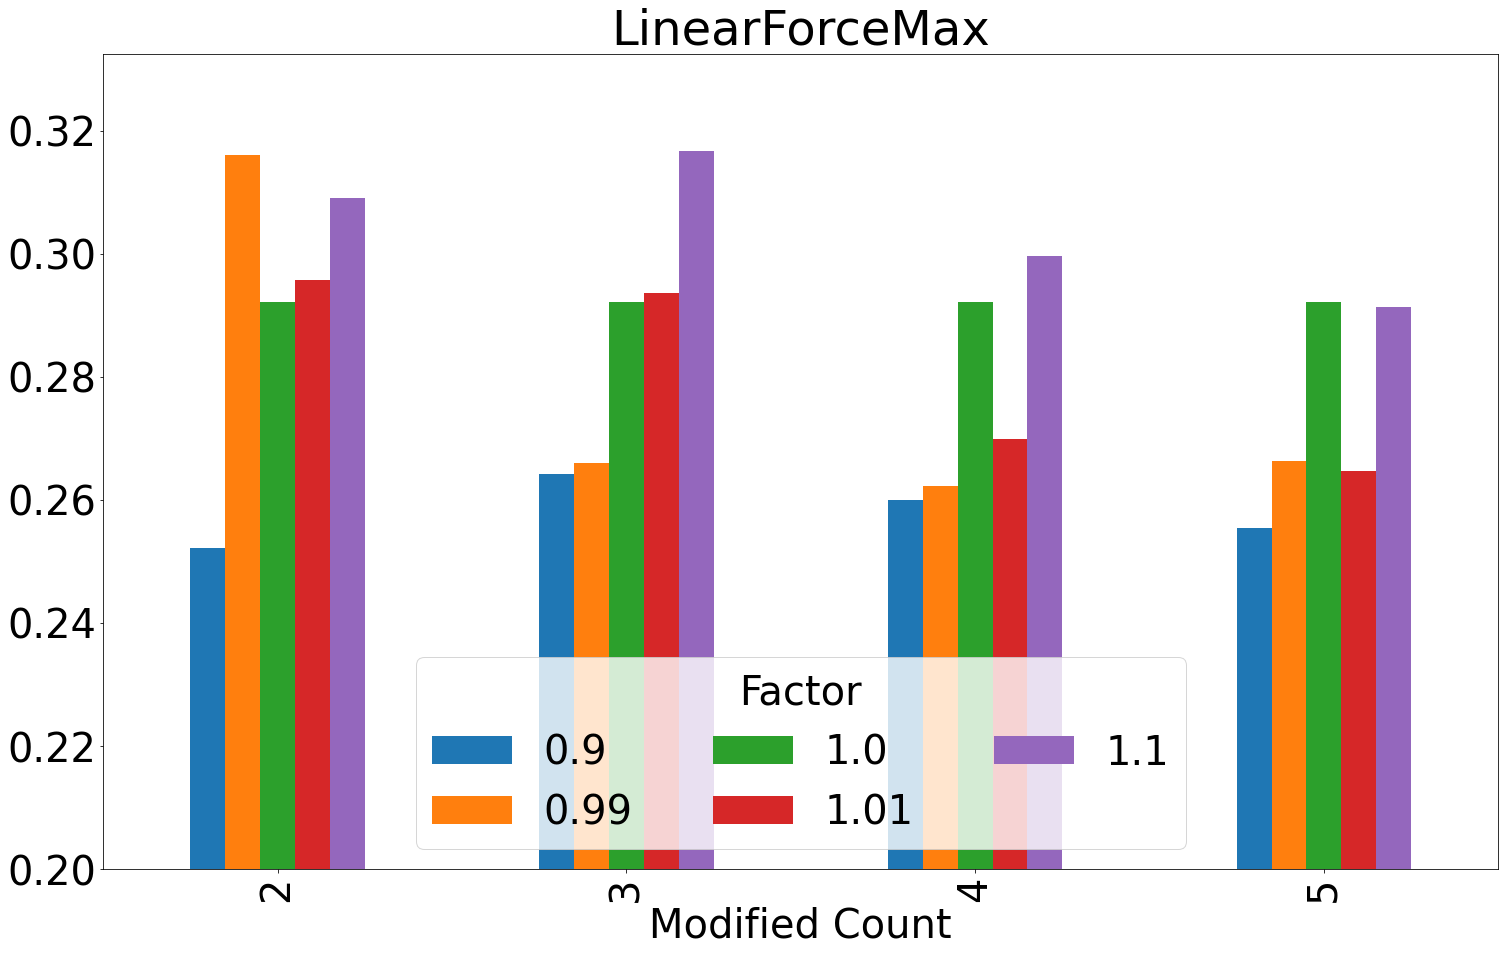

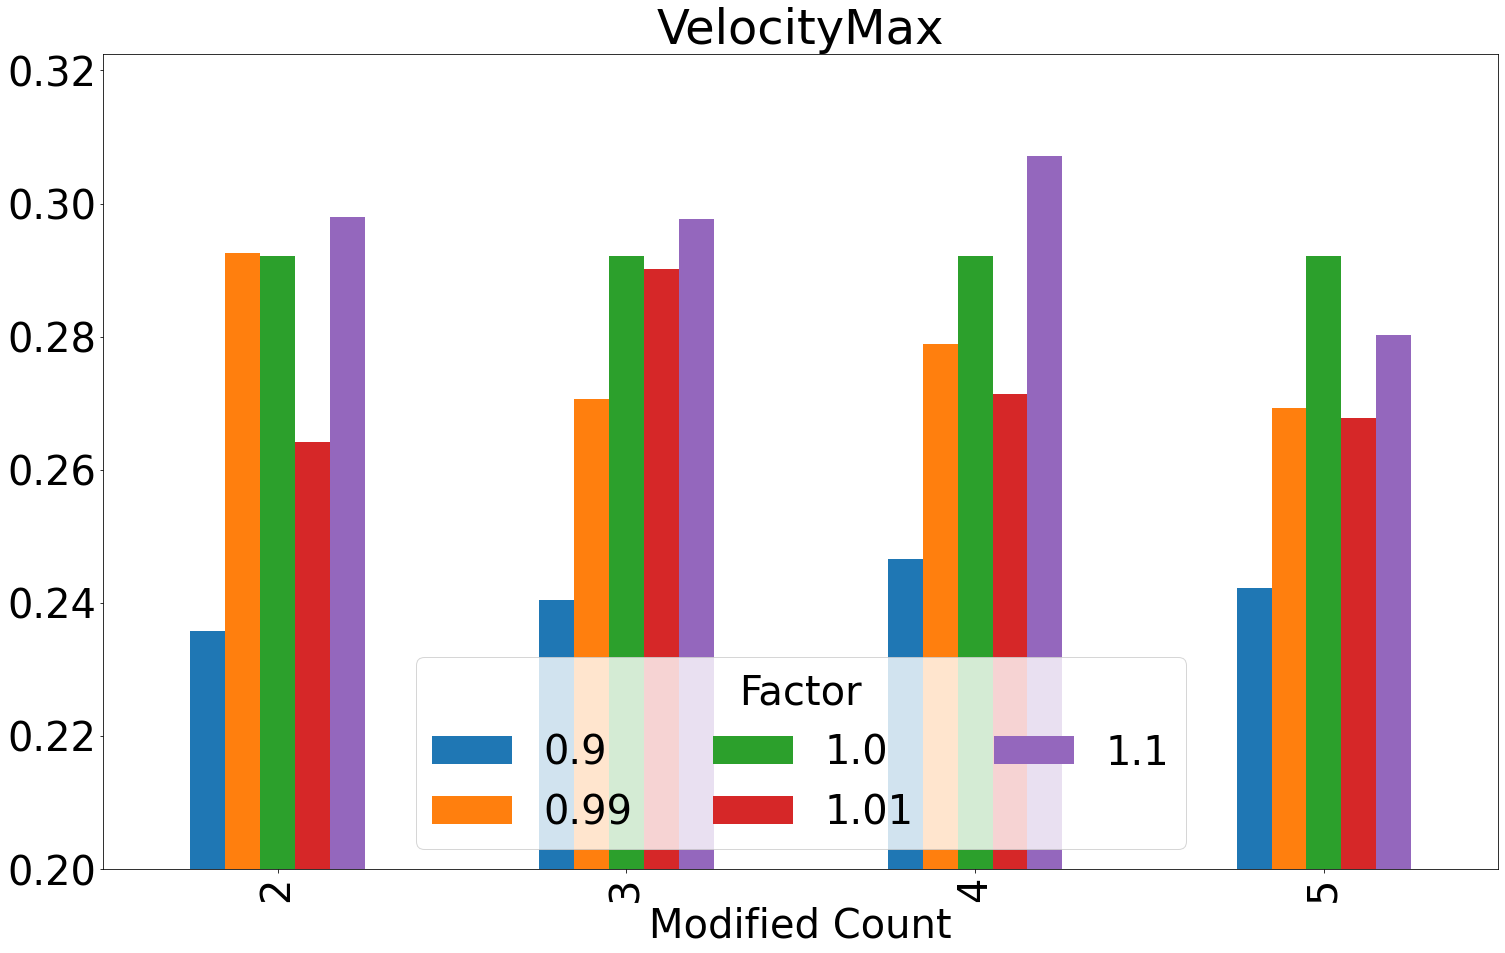

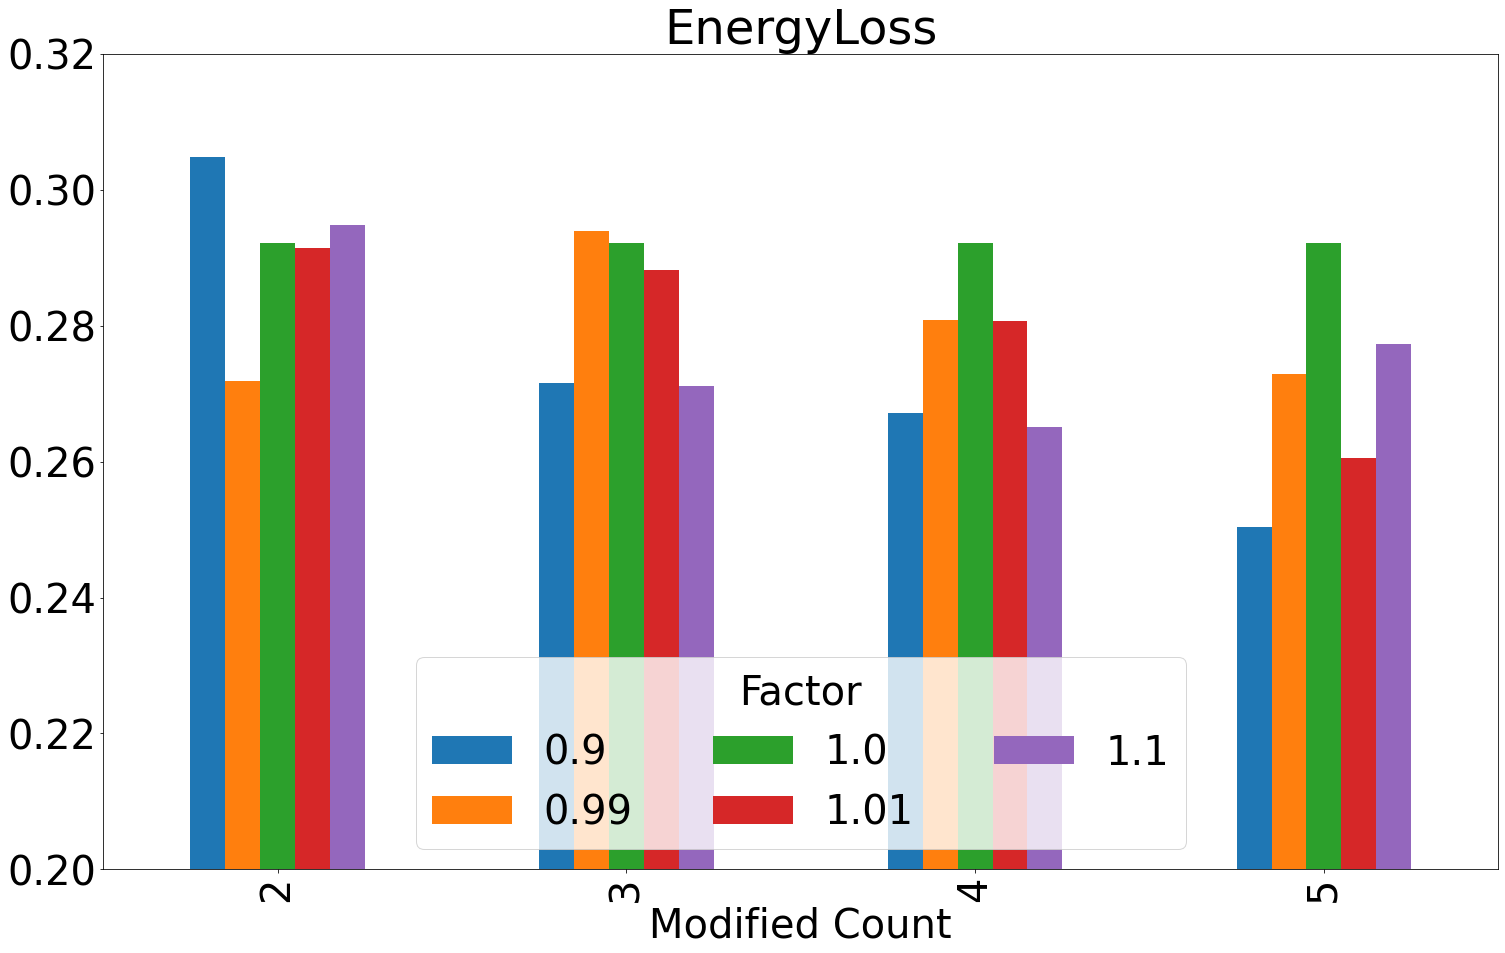

In [28]:
def print_sensitivity(param):
    sensitivity_combination2 = sensitivity_combination_all
    l = lambda x: param in x
    sensitivity_combination2 = sensitivity_combination2[sensitivity_combination2['Modified Values'].dropna().apply(l)]
    sensitivity_combination2 = pd.concat([sensitivity_combination2, sensitivity_combination_all[sensitivity_combination_all['Modified Values'].isna()]])
    return pd.pivot_table(sensitivity_combination2, index='Modified Count', columns='Factor')

parameters = set(itertools.chain(*sensitivity_combination_all['Modified Values'].dropna().values))
for p in parameters:
    f = print_sensitivity(p).plot.bar(figsize=(25,15), y='Energy Mean', sharey=True)
    f.legend(ncol=3, loc='lower center', title='Factor')
    f.set_ylim(bottom=0.20)
    f.set_title(p)
    f.get_figure().savefig('Figures/sensitivity_combination_' + p)

Same as previous section but as heatmap instead of a bar plot.

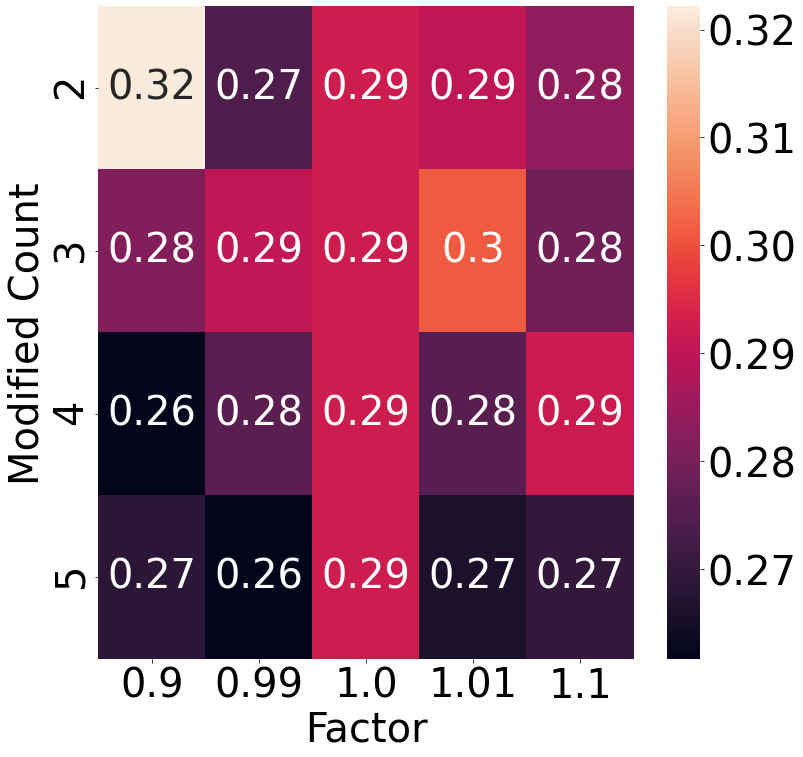

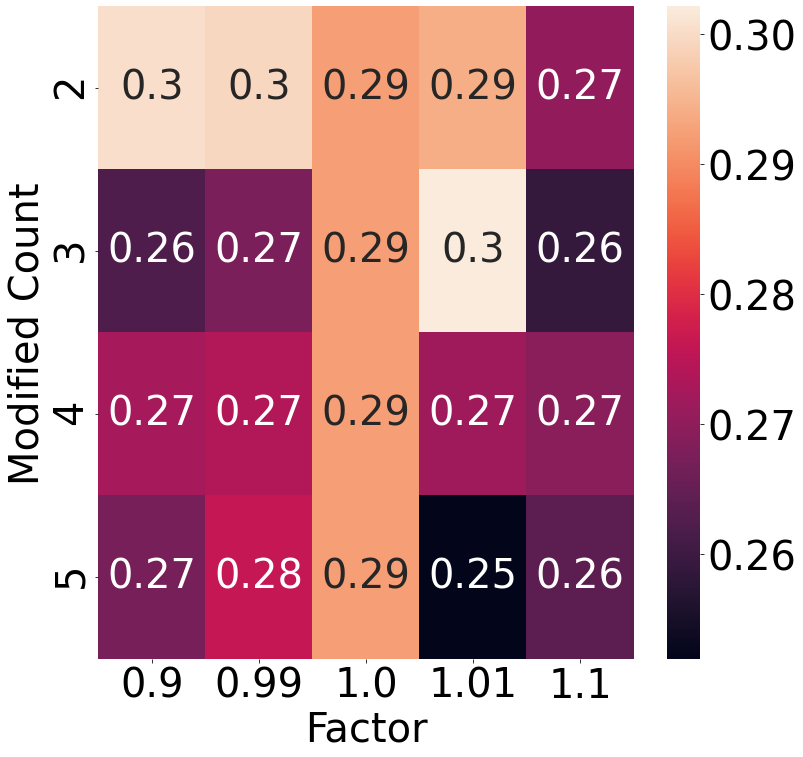

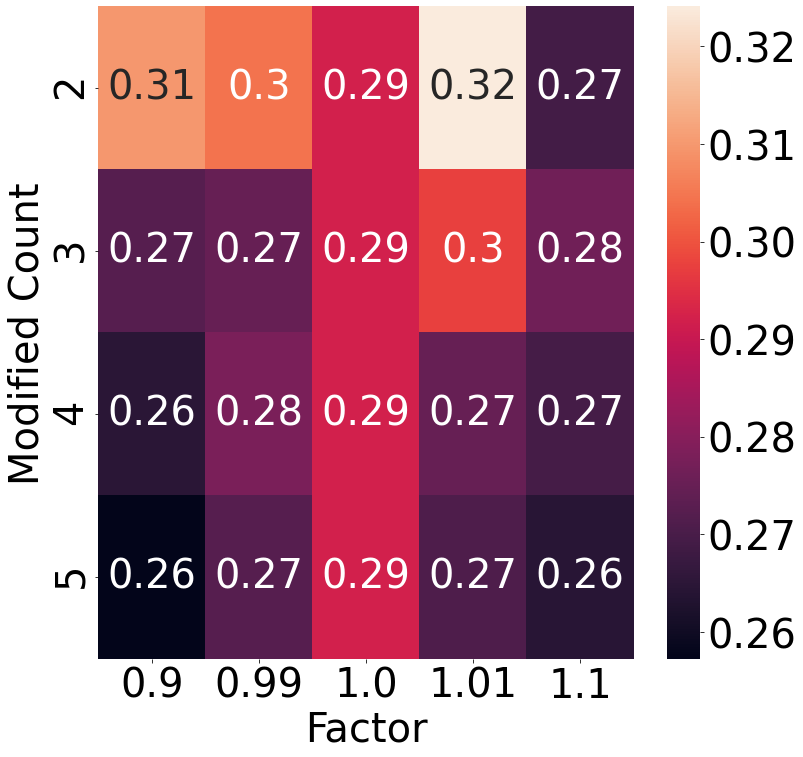

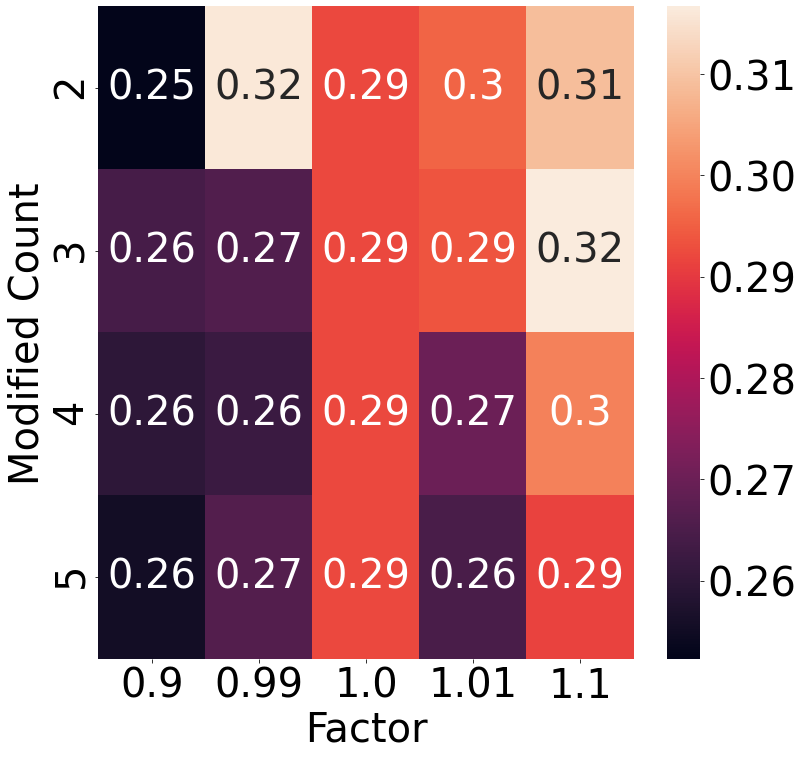

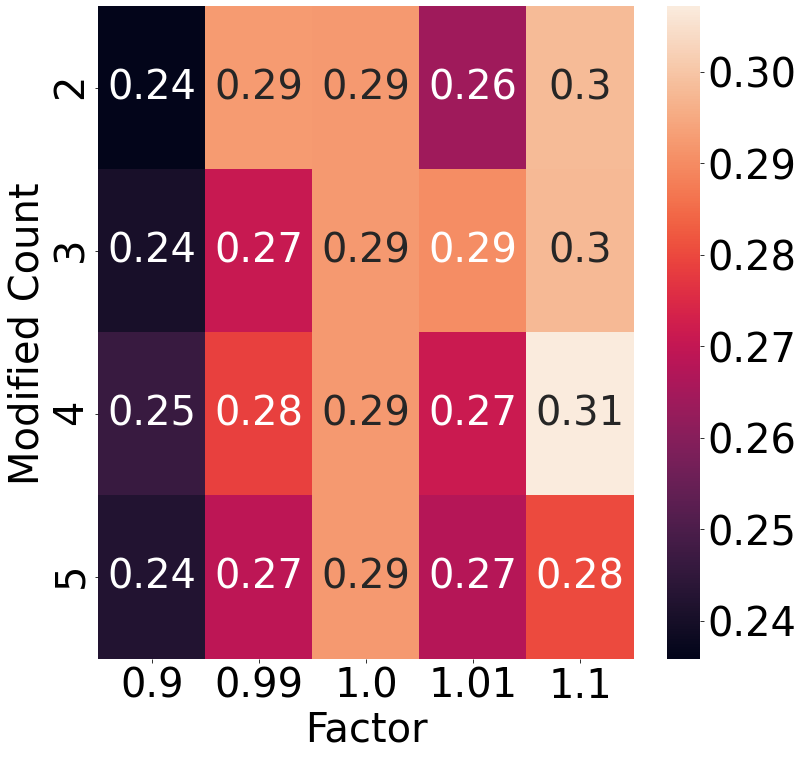

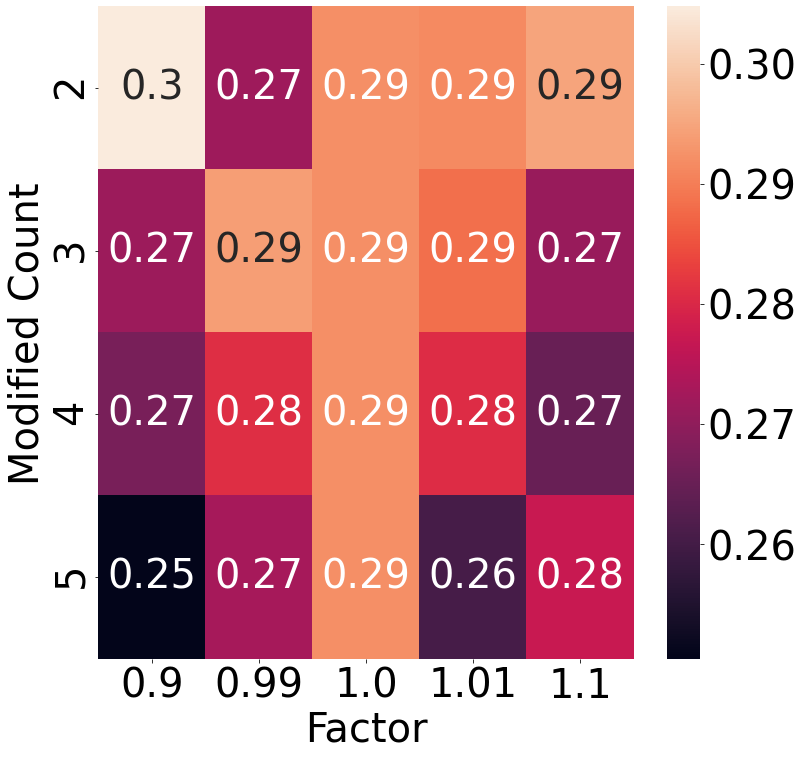

In [29]:
for p in parameters:
    a = print_sensitivity(p)
    plt.figure(figsize = (12,12))
    sns.heatmap(a['Energy Mean'], annot=True)

Heaptmaps of the mean energy in relation to the factor. Samples are divided based on the number of modifed values.

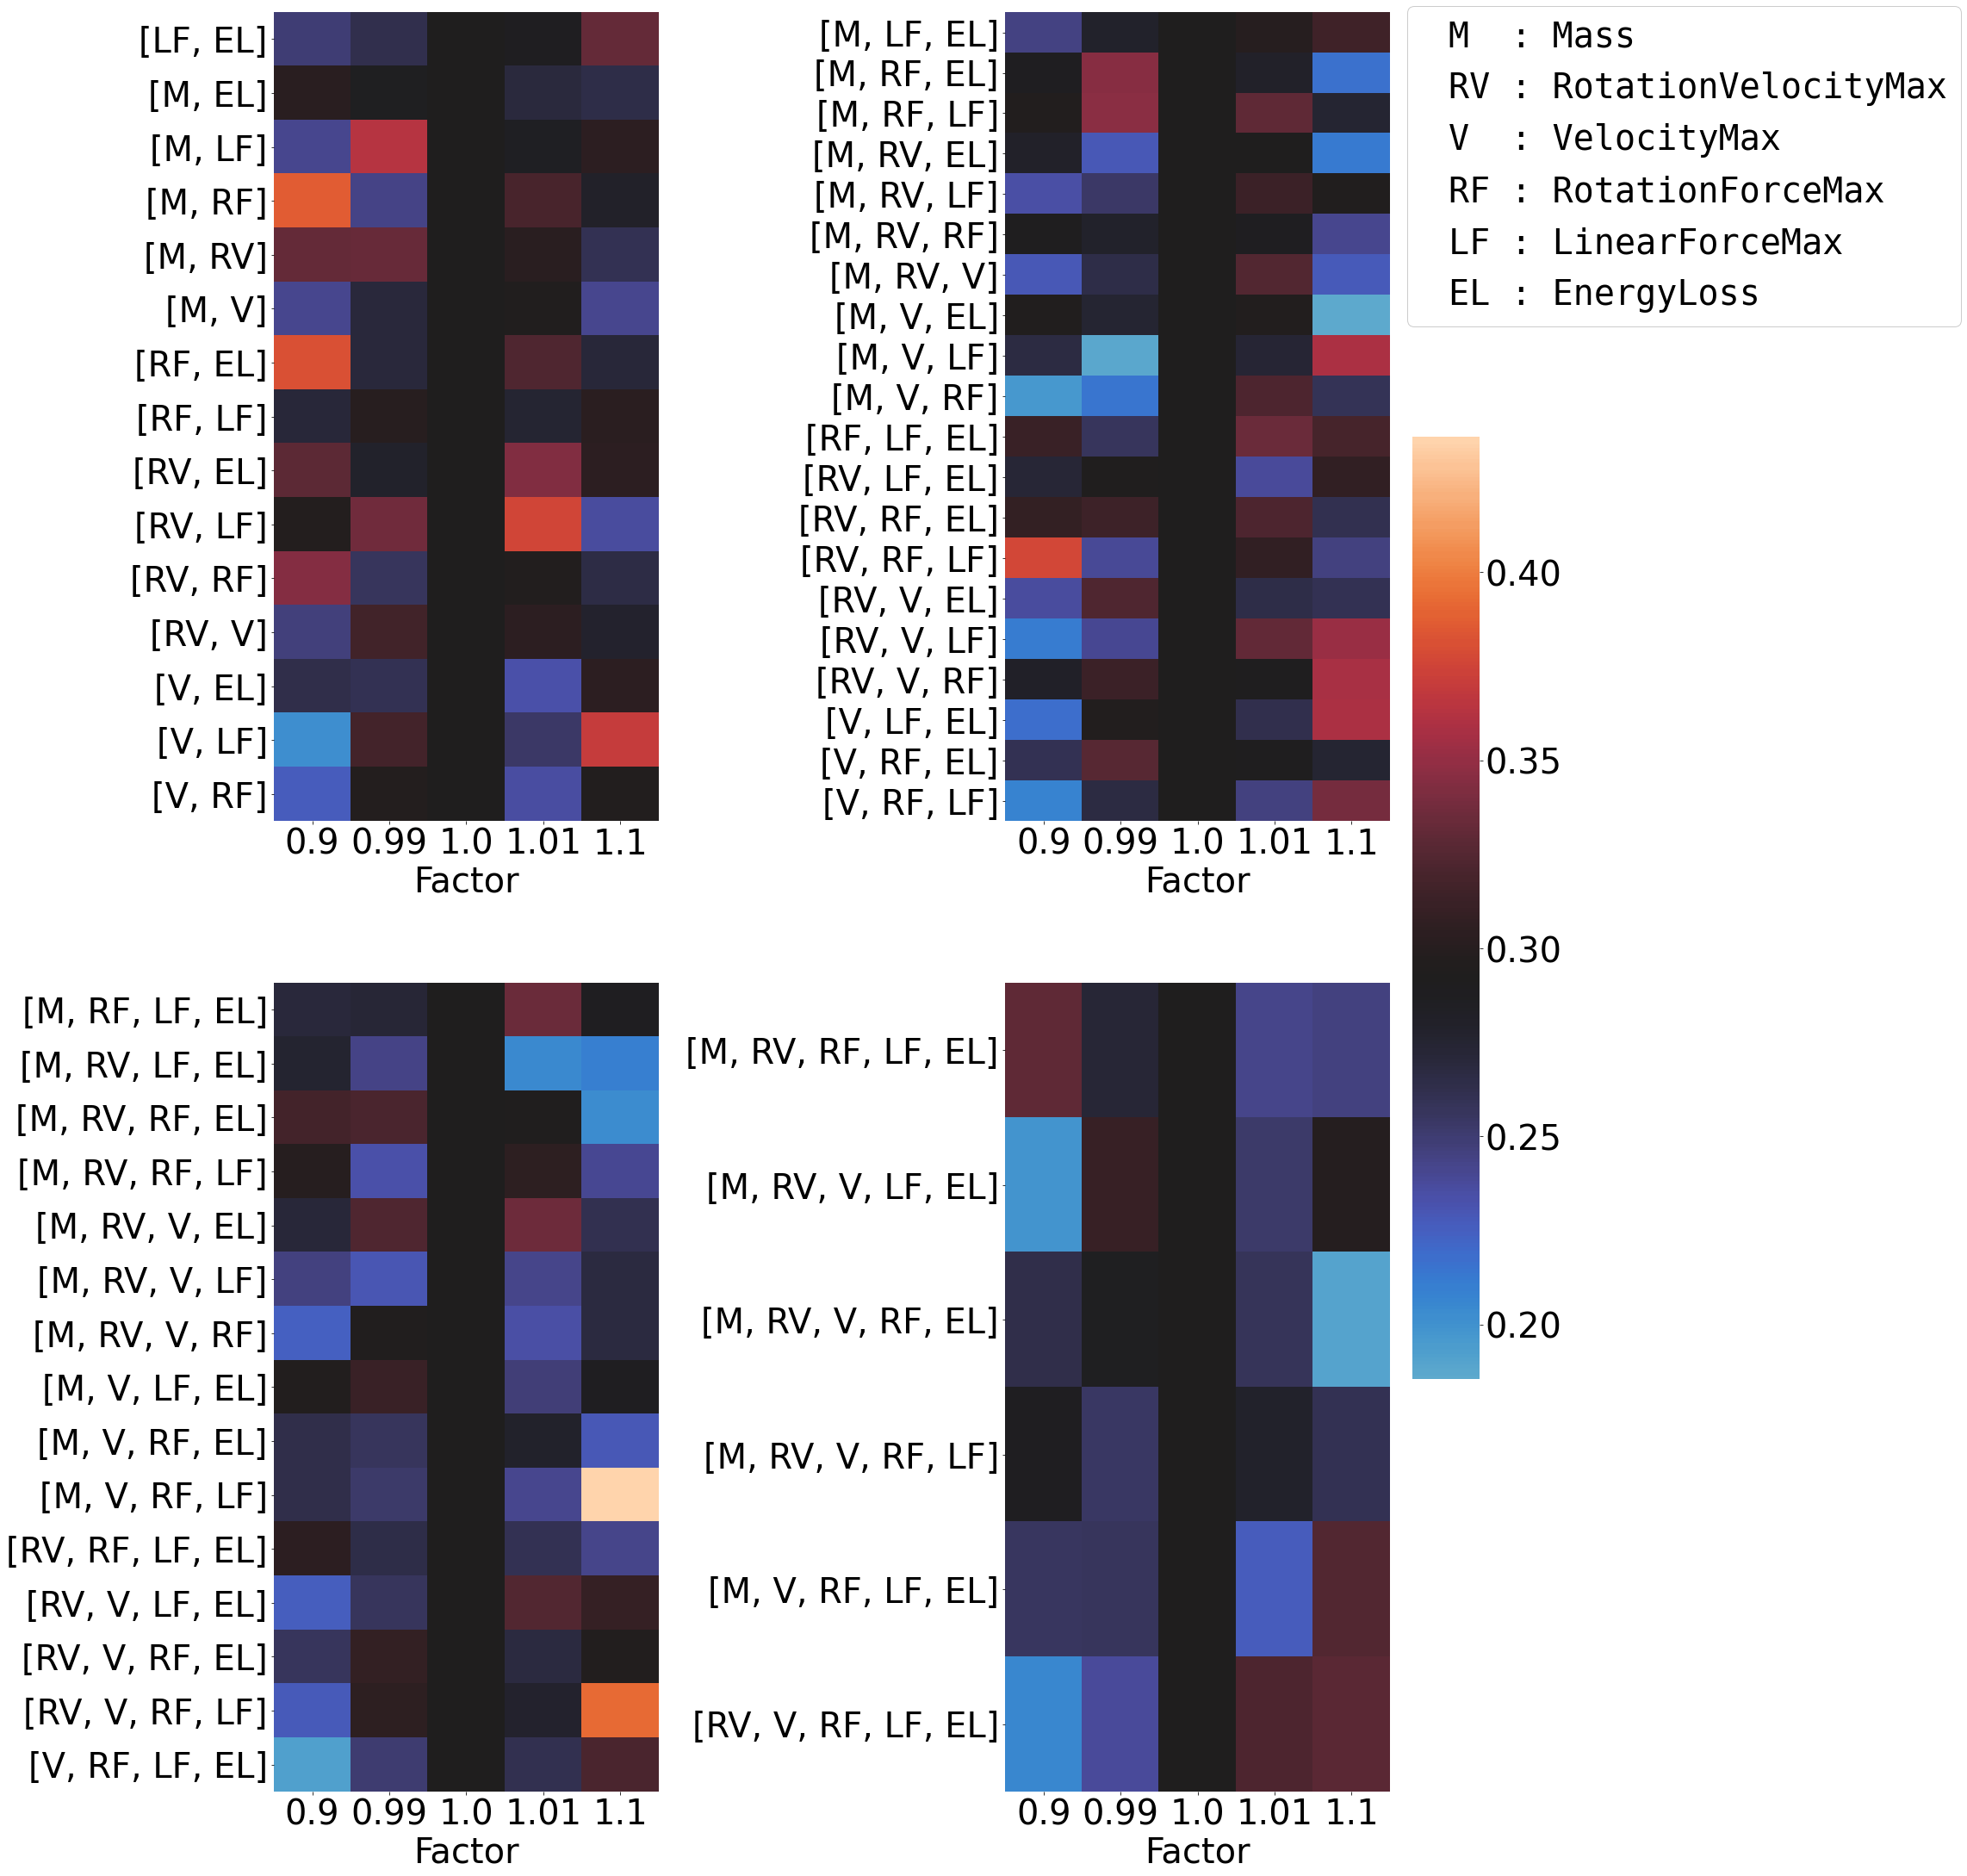

In [40]:
shortened_names = {
    'Mass' : 'M',
    'RotationVelocityMax' : 'RV',
    'VelocityMax' : 'V',
    'RotationForceMax' : 'RF',
    'LinearForceMax' : 'LF',
    'EnergyLoss' : 'EL'
}

sensitivity_combination_all['Modified Values Str'] = sensitivity_combination_all['Modified Values'].map(lambda values: [shortened_names[key] for key in values]).apply(str).apply(lambda x: x.replace('\'',''))
sen_pivot = sensitivity_combination_all.sort_values(by='Modified Count').pivot('Modified Values Str', 'Factor')
sen_pivot.sort_values(by=('Modified Count',1.0), inplace=True)
center = sensitivity_combination_all[sensitivity_combination_all['Factor'] == 1]['Energy Mean'].mean()

fig, axes = plt.subplots(2,2, figsize = (36,38))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
min_energy = sensitivity_combination_all['Energy Mean'].min()
max_energy = sensitivity_combination_all['Energy Mean'].max()
i = True
for name, group in sensitivity_combination_all.groupby('Modified Count'):
    pivot = group.pivot('Modified Values Str', 'Factor')
    g = sns.heatmap(pivot['Energy Mean'], center=center, ax=axes.flat[name-2],
                    vmax=max_energy, vmin=min_energy, cbar=i,
                    cbar_ax= cbar_ax if i else None)
    g.set_ylabel('')
    plt.subplots_adjust(left=0.4, wspace=0.9)
    i = False

mono_font = {'fontname':'monospace'}
s = [": ".join((v.ljust(3), k)) for k,v in shortened_names.items()]
font = font_manager.FontProperties(family='monospace')
legend_elements = [Line2D([0], [0],  label=": ".join((v.ljust(3), k))) for k,v in shortened_names.items()]

legend = fig.legend(handles=legend_elements, prop=font, handlelength=0, loc='upper left', bbox_to_anchor=(0.9, 0.89))
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

fig.savefig('Figures/sensitivity_combination_combination_all_heat', bbox_inches='tight')

Information about the number of samples that have a lower or higher mean energy than the used base sample.

In [63]:
def print_stats(data_1, target):
    total = data_1.count()
    lower = data_1[data_1 < target].count()
    higher = data_1[data_1 > target].count()
    print("Total: " + str(total))
    print("Lower: " + str(lower) + " (" + str(round(lower/total*100, 2)) + " %)")
    print("Higher: " + str(higher) + " (" + str(round(higher/total*100, 2)) + " %)")
    print("Ratio: " + str(round(higher/lower,2)))

for name, group in sensitivity_combination_all.groupby('Modified Count'):
    print(name)
    print_stats(group['Energy Mean'], center)

print("All")
print_stats(sensitivity_combination_all['Energy Mean'], center)

2
Total: 75
Lower: 31 (41.33 %)
Higher: 44 (58.67 %)
Ratio: 1.42
3
Total: 100
Lower: 47 (47.0 %)
Higher: 53 (53.0 %)
Ratio: 1.13
4
Total: 75
Lower: 40 (53.33 %)
Higher: 35 (46.67 %)
Ratio: 0.88
5
Total: 30
Lower: 18 (60.0 %)
Higher: 12 (40.0 %)
Ratio: 0.67
All
Total: 280
Lower: 136 (48.57 %)
Higher: 144 (51.43 %)
Ratio: 1.06


Parameter data as latex table

In [36]:
column_mappings = {
    'Sample Id': 'Sample ID',
    'Mass': '$M$',
    'Rotation Velocity Max': '$RV_{max}$',
    'Velocity Max': '$V_{max}$',
    'Rotation Force Max': '$RF_{max}$',
    'Linear Force Max': '$LF_{max}$',
    'Energy Loss': '$EL$',
    'Consumption Rate': '$CR$'
}

def try_get_index(value):
    a = value.split('_')
    if len(a) < 2:
        return value
    if '-' in a[-1]:
        return int(a[-1].split('-')[-1])
    else:
        return int(a[-1])

with open('Tables/Parameter_Data.txt', 'w+') as file:
    for run, data in parameter_df.groupby('Run Id'):
        data['Sample Id'] = data['Sample Id'].apply(lambda x: x.replace('_', '\_'))
        data = data.drop(columns='Run Id')\
            .rename(columns=column_mappings)\
            .set_index('Sample ID')
        try:
            data = data.reindex(index=data.index.to_series().apply(try_get_index).sort_values().index)
        except ValueError:
            pass
        file.write(data.to_latex(float_format='%.2f', longtable=True,
                      escape=False, caption=run.replace('_','\_')) + '\n')

Sensitivity_all base samples as table

In [37]:
s_all_index = sensitivity_all.reset_index()[['Base Run','Base Sample']].drop_duplicates()
s_all_data = metadata_df.loc[s_all_index.itertuples(index=False)] \
    [['Energy Mean', *parameter_df.columns.difference(index_columns)]]

with open('Tables/Sensitivity_all_base_runs.txt', 'w+') as file:
    file.write(s_all_data.to_latex(float_format='%.2f', escape=False) + '\n')

Performance difference between Sample_min (Top_run) and rest (average)

In [38]:
s_max = metadata_df.xs('Top_Run')['Energy Mean']['Sample_Max']
s_mean = metadata_df.xs('Top_Run')['Energy Mean']['Sample_Mean']
s_min = metadata_df.xs('Top_Run')['Energy Mean']['Sample_Min']
s_min * 100 / ((s_mean+s_max)/2)

82064.94973693755